In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from ukb_gwas import*
import matplotlib.cm as cm

In [2]:
def boltChromPositionsPvals(bolt_gwas_df):
    positions = {}
    pvals = {}
    for chrom in np.arange(1,23):
        positions[chrom] = bolt_gwas_df[bolt_gwas_df.CHR==chrom].BP.tolist()
        pvals[chrom] = -np.log10(bolt_gwas_df[bolt_gwas_df.CHR==chrom].P_BOLT_LMM_INF.values)
    return positions, pvals

def manhattanPlot(positions, pvals, max_y=0, snp_locs={}):

    plt.style.use('default')
    f,a = plt.subplots(1,1,figsize=(9,3), dpi = 300)

    cols = cm.get_cmap('tab10')
    colorval = 0
    
    xscale = 1000
    x_start_chrom = 0
    previous_chrom_length = 0
    x_chrom_labels = []
    
    for chrom in sorted(positions.keys()):
        
        # where should this chromosome start?
        x_start_chrom = x_start_chrom + previous_chrom_length
        
        # show highlighted snps if present
        if len(snp_locs) > 0 and chrom in snp_locs.keys():
            for pos in snp_locs[chrom]:
                pos = pos / xscale
                pos = pos + x_start_chrom
                a.plot([pos,pos],[0,max_y],':',linewidth=1, color='darkgrey')

        # get color for scatter
        if colorval < 1:
            col = cols(colorval)
            colorval += 0.11
        else:
            col = cols(0)
            colorval = 0.11
        
        # how long should this chromosome go?
        bp = np.array(positions[chrom])
        previous_chrom_length = max(bp) / xscale
        
        # where should points go?
        xpos = bp / xscale
        xpos = xpos + x_start_chrom

        # where should chromosome label go?
        x_chrom_labels.append(x_start_chrom + previous_chrom_length/2)

        # get pvals
        y = pvals[chrom]

        # plot
        a.scatter(xpos, y , c = [col], s = 10)

    # show genome wide significance
    sigVal = -np.log10(5e-8)
    plt.plot([0,np.max(xpos)],[sigVal,sigVal],'--r',linewidth=1)
    
    # label axes
    xlabs = [str(x) for x in sorted(positions.keys())]
    xtickPos = [x-0.5 for x in sorted(positions.keys())]
    plt.xticks(x_chrom_labels,xlabs,fontsize=10,rotation = 90)
    plt.xlabel('Chromosome', fontsize = 16)
    plt.ylabel('-log10(p)', fontsize = 16)
    
    # set max y axis, if specified 
    if max_y > 0:
        plt.ylim([0,max_y])
    
    # span the length of the x axis
    plt.xlim([0,x_start_chrom + previous_chrom_length])
    
    plt.show()
    
# extract a specific trait from the GWAS catalog . . .
def get_top_snps_from_gwas(gwas_catalog,traits,traitlist):
    import operator
    theseTraits = []
    for s in traitlist:
        theseTraits.extend([x for x in traits if s == x])
    
    # get list of snps
    trait_df = gwas_catalog[gwas_catalog['DISEASE/TRAIT'].isin(traitlist)]
    trait_snps_raw = trait_df['STRONGEST SNP-RISK ALLELE'].tolist()
    trait_snps = [x.split('-')[0] for x in trait_snps_raw]

    # get pvals for these snps
    trait_pvals = [float(x) for x in trait_df['P-VALUE'].values]
    
    # make dictionary of snps => pvals
    pval_dict = dict(zip(trait_snps,trait_pvals))
    
    # sort keys by values, in ascending order
    sorted_items = sorted(pval_dict.items(), key=operator.itemgetter(1))
    sorted_snps = [x[0] for x in sorted_items]
    
    return list(set(sorted_snps)), pval_dict

def get_position_dict(snplist,gwas_catalog_positions):
    snp_locs = {}
    for snp in snplist:
        
        if 'x' in gwas_catalog_positions[snp]: # some GWAS catalog entries have interactions, skip these
            position = 0
        elif ';' in gwas_catalog_positions[snp]: # some GWAS catalog entried have multiple snps, choose 1st
            chrom = int(gwas_catalog_positions[snp].split(';')[0])
            position = int(float(gwas_catalog_positions[snp].split(':')[1].split(';')[0]))
        elif 'nan' not in gwas_catalog_positions[snp]:       
            chrom = int(gwas_catalog_positions[snp].split(':')[0])
            position = int(float(gwas_catalog_positions[snp].split(':')[1]))
            
        if position > 0:
            if chrom in snp_locs.keys():
                snp_locs[chrom].append(position)
            else:
                snp_locs[chrom] = [position]
    for chrom in snp_locs.keys():
        snp_locs[chrom] = sorted(snp_locs[chrom])
    return snp_locs

# getting standard snp set for EDUYEARS
eduyears_lead_snps = pd.read_excel('41588_2018_147_MOESM3_ESM.xlsx', 
                                  sheet_name = '2. EduYears Lead SNPs',
                                  skipfooter = 2, header = 1, index_col = None )
snplist = eduyears_lead_snps.sort_values(by='P-value',ascending=True).SNP.tolist()
ea_snps = snplist
# add these snp positions to manhattan plot?
num_to_get = 25
topPvals = eduyears_lead_snps.sort_values(by='P-value',ascending = True).head(num_to_get)

# make dictionary ... key = Chr, vals = list of positions
ea_snp_locs = {}
for chrom in np.arange(1,23):
    thisChrom = topPvals[topPvals.Chr==chrom].Position.tolist()
    if len(thisChrom) > 0:
        ea_snp_locs[chrom] = sorted(thisChrom)

# mover status GWAS

In [11]:
moverstatus_gwas = pd.read_csv('bolt_moverstatus_allwba_eacovar/lmm_moverstatus_allwba.tab',delimiter = '\t')
positionDict, pvalDict = boltChromPositionsPvals(moverstatus_gwas)
mover_status_pvals = dict(zip(moverstatus_gwas.SNP,moverstatus_gwas.P_BOLT_LMM_INF))
moverstatus_gwas.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF
0,rs3131962,1,756604,0.004907,A,G,0.129818,0.0,-0.000412,0.001564,0.79
1,rs12562034,1,768448,0.004957,G,A,0.895030,0.0,-0.002313,0.001712,0.18
2,rs4040617,1,779322,0.005007,A,G,0.872176,0.0,-0.000355,0.001573,0.82


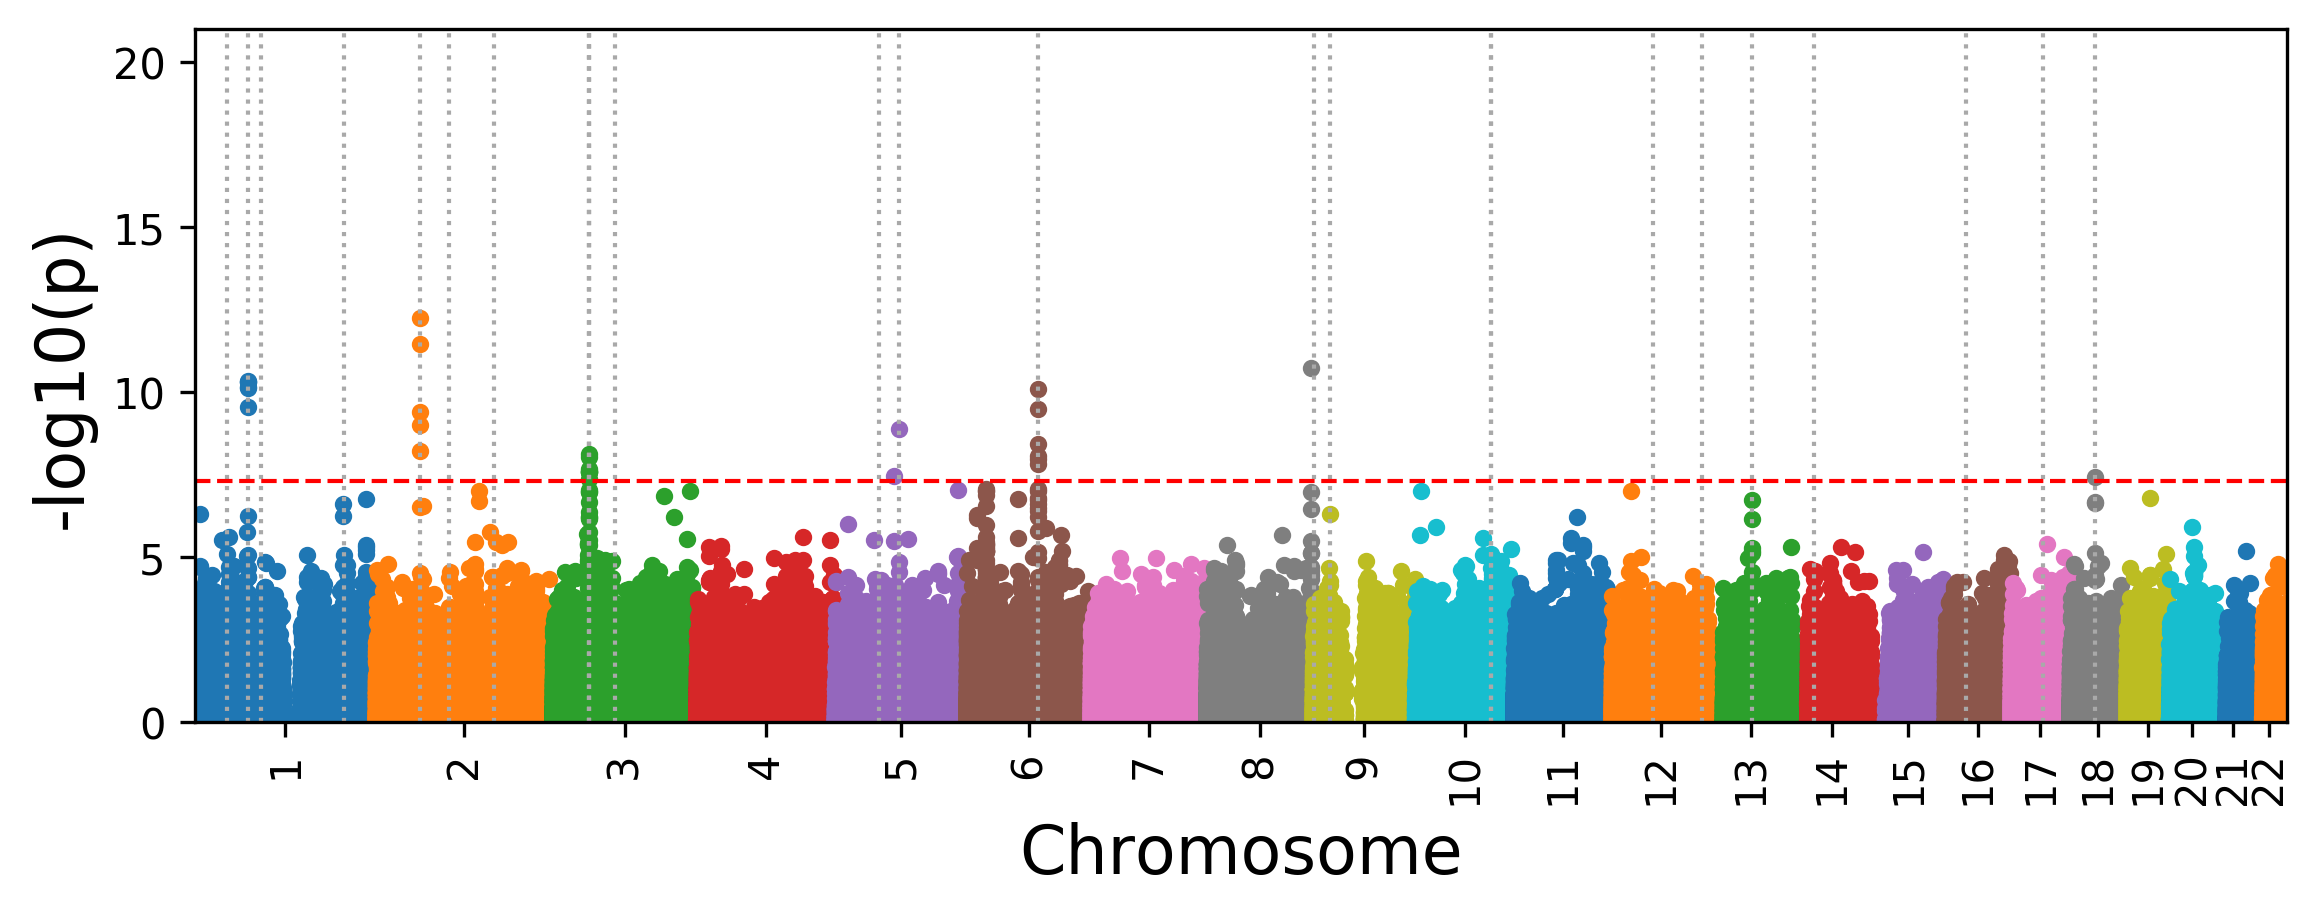

In [12]:
manhattanPlot(positionDict, pvalDict , 21, ea_snp_locs)

In [6]:
gwas_catalog = pd.read_csv('gwas_catalog_pruned.tsv',delimiter = '\t')
traits = list(set(gwas_catalog['DISEASE/TRAIT'].tolist()))
gwas_catalog_snps = [x.split('-')[0] for x in gwas_catalog['STRONGEST SNP-RISK ALLELE'].tolist()]
gwas_catalog_chr = gwas_catalog.CHR_ID.tolist()
gwas_catalog_pos = gwas_catalog.CHR_POS.tolist()
chrom_positions = [str(gwas_catalog_chr[i]) + ':' + str(pos) for i,pos in enumerate(gwas_catalog_pos)]
gwas_catalog_positions = dict(zip(gwas_catalog_snps,chrom_positions))
gwas_catalog.head(3)

,STUDY,DISEASE/TRAIT,CHR_ID,CHR_POS,STRONGEST SNP-RISK ALLELE,RISK ALLELE FREQUENCY,P-VALUE,PVALUE_MLOG,P-VALUE (TEXT),OR or BETA,95% CI (TEXT),PLATFORM [SNPS PASSING QC],CNV
0,Identification of novel genetic markers associ...,systemic sclerosis,6,32441753,rs3129882-?,0.44,2E-27,26.69897,(ATA positive),2.17,[1.88-2.50],Illumina [NR] (imputed),N
1,Identification of novel genetic markers associ...,systemic sclerosis,6,33075103,rs987870-?,0.15,2E-20,19.69897,(ATA positive),2.09,[1.78-2.45],Illumina [NR] (imputed),N
2,Identification of novel genetic markers associ...,systemic sclerosis,6,32623148,rs3129763-?,0.25,1E-11,11.00000,(ATA positive),1.65,[1.42-1.91],Illumina [NR] (imputed),N


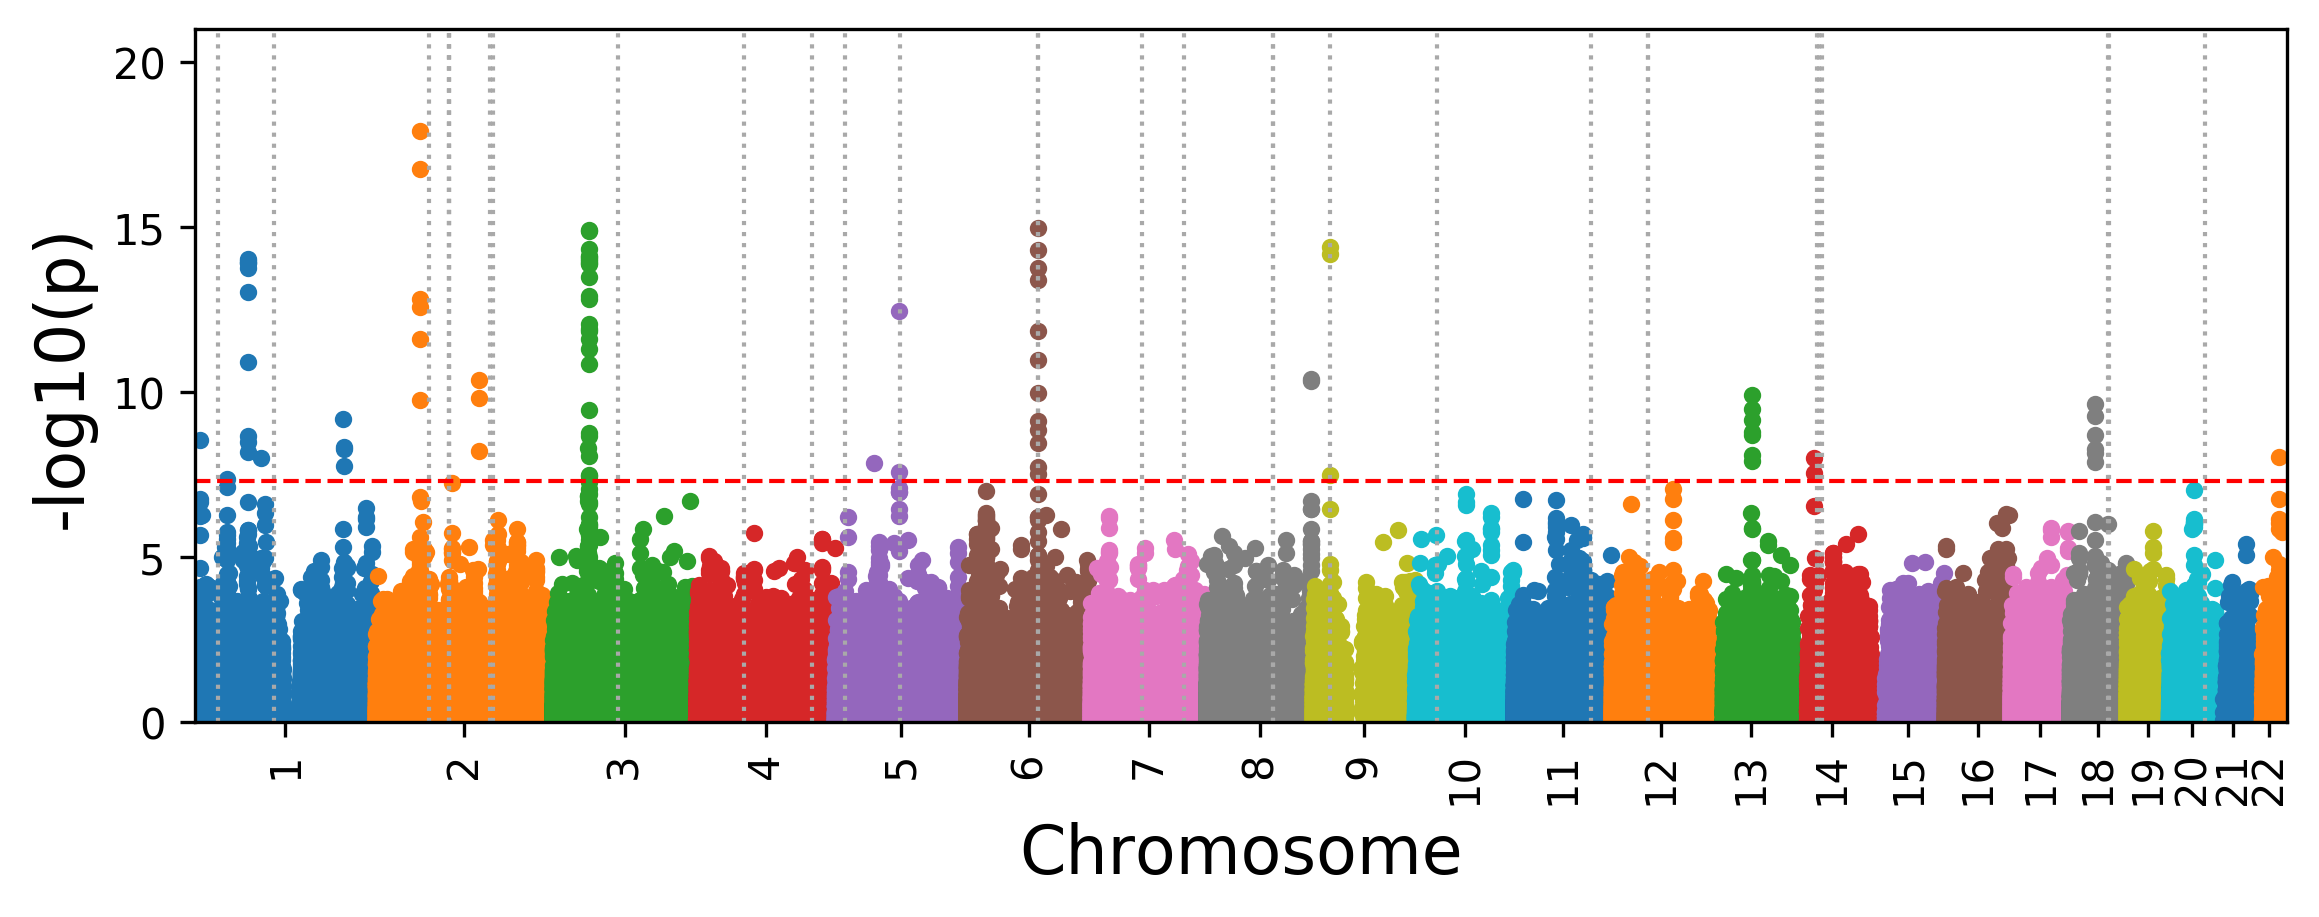

In [10]:
intelligence = ['intelligence','cognitive ability','cognitive ability (mtag)','extremely high intelligence']
intelligence_snps, intelligence_pvals = get_top_snps_from_gwas(gwas_catalog,traits,intelligence)
intelligence_snp_locs = get_position_dict(intelligence_snps[:30],gwas_catalog_positions)
intelligence_ps = [intelligence_pvals[x] for x in intelligence_snps]
manhattanPlot(positionDict, pvalDict, 21, intelligence_snp_locs)

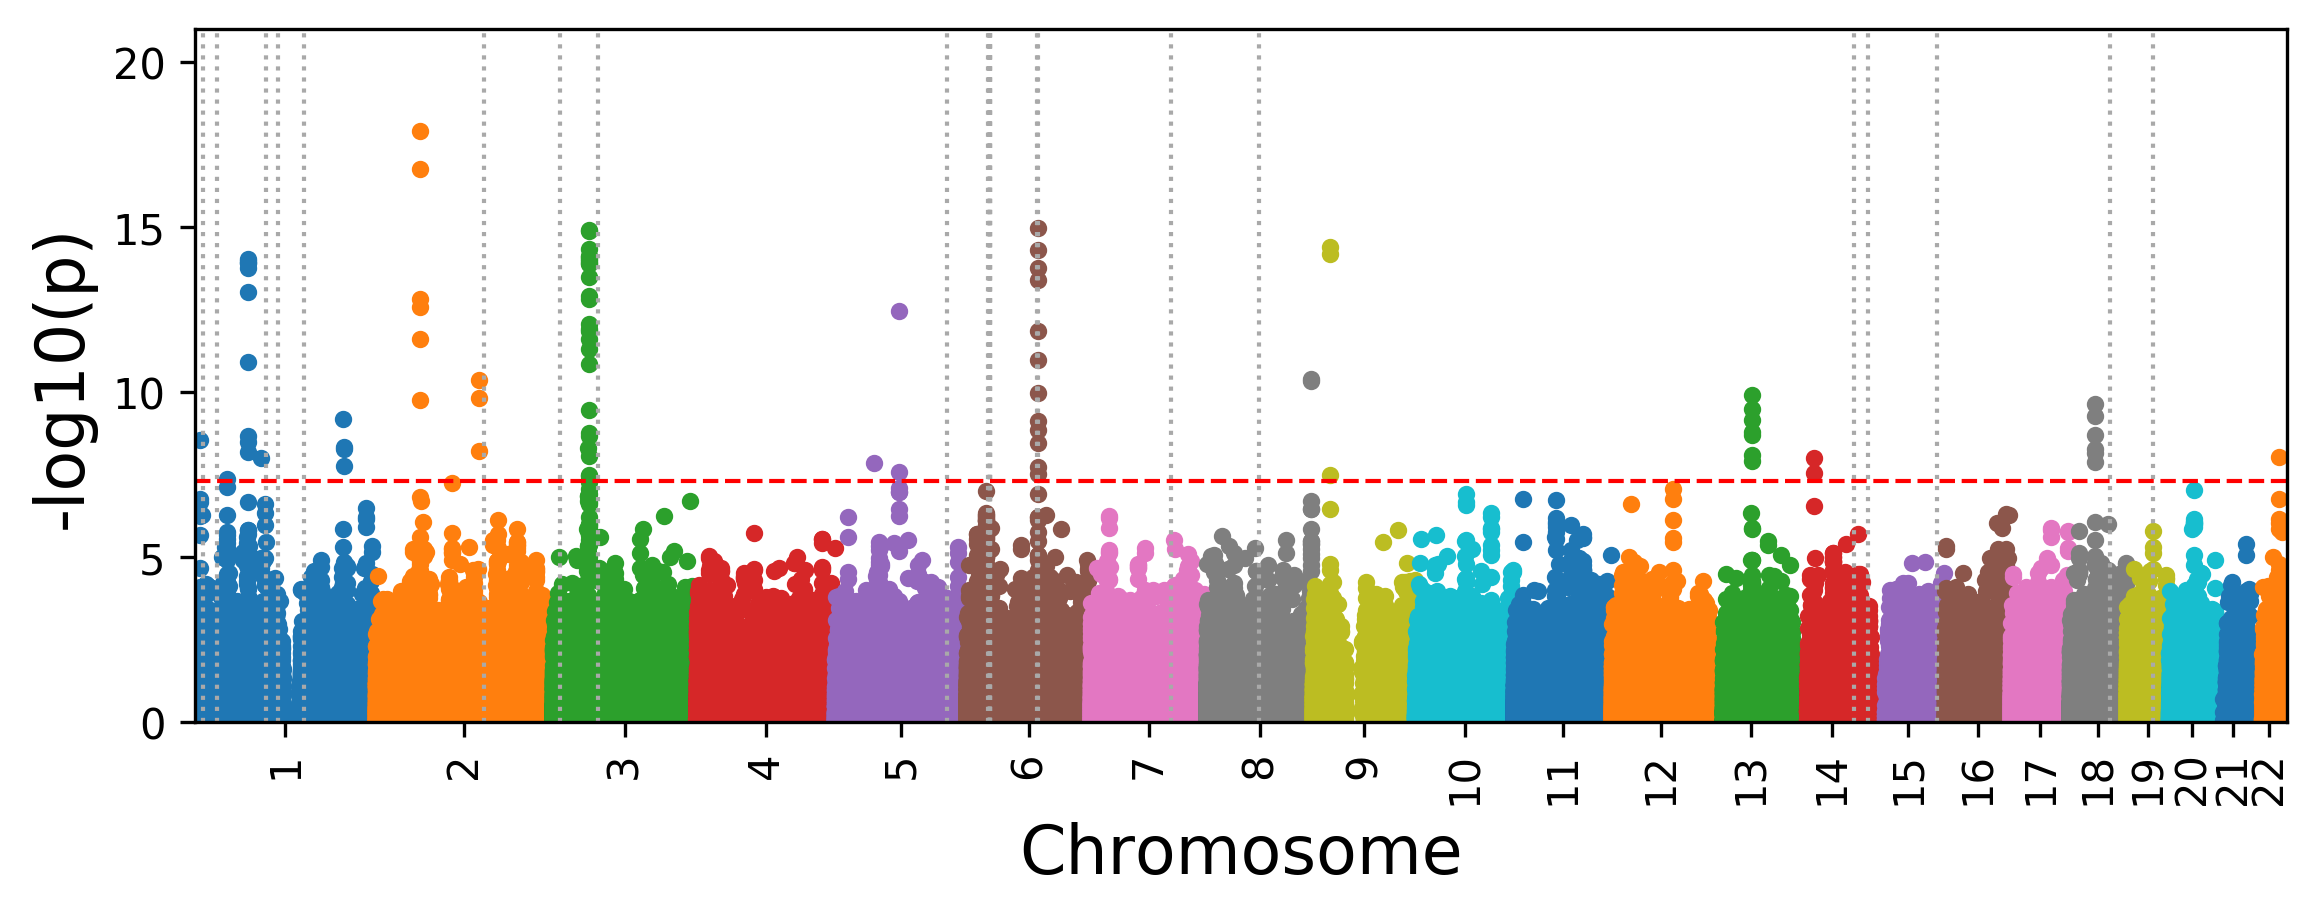

In [12]:
autismTraits = [x for x in traits if 'autism' in x]
autism_snps, autism_pvals = get_top_snps_from_gwas(gwas_catalog,traits,autismTraits)
autism_snp_locs = get_position_dict(autism_snps[:25],gwas_catalog_positions)
autism_ps = [autism_pvals[x] for x in autism_snps]
manhattanPlot(positionDict, pvalDict, 21, autism_snp_locs)

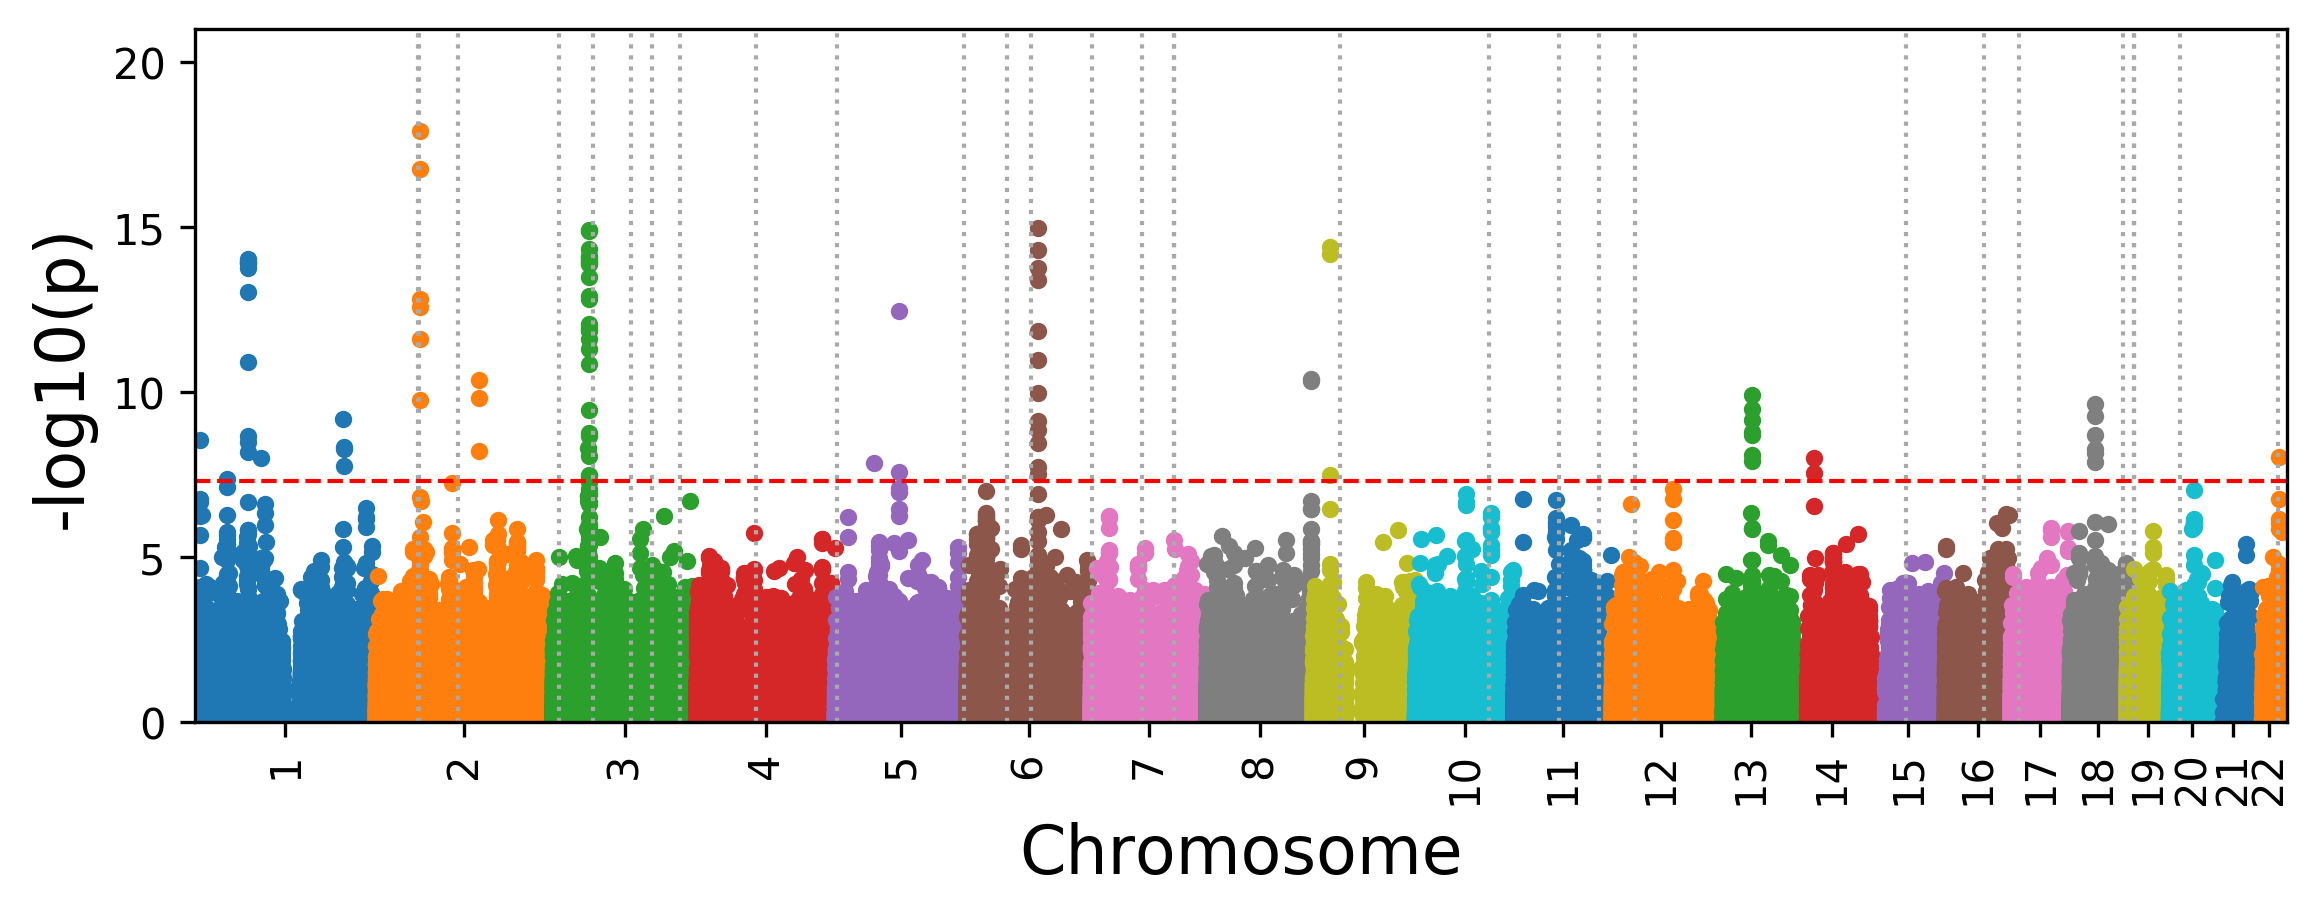

In [13]:
sleep = ['sleep duration']
sleep_snps, sleep_pvals = get_top_snps_from_gwas(gwas_catalog,traits,sleep)
sleep_snp_locs = get_position_dict(sleep_snps[:30],gwas_catalog_positions)
sleep_ps = [sleep_pvals[x] for x in sleep_snps]
manhattanPlot(positionDict, pvalDict, 21, sleep_snp_locs)

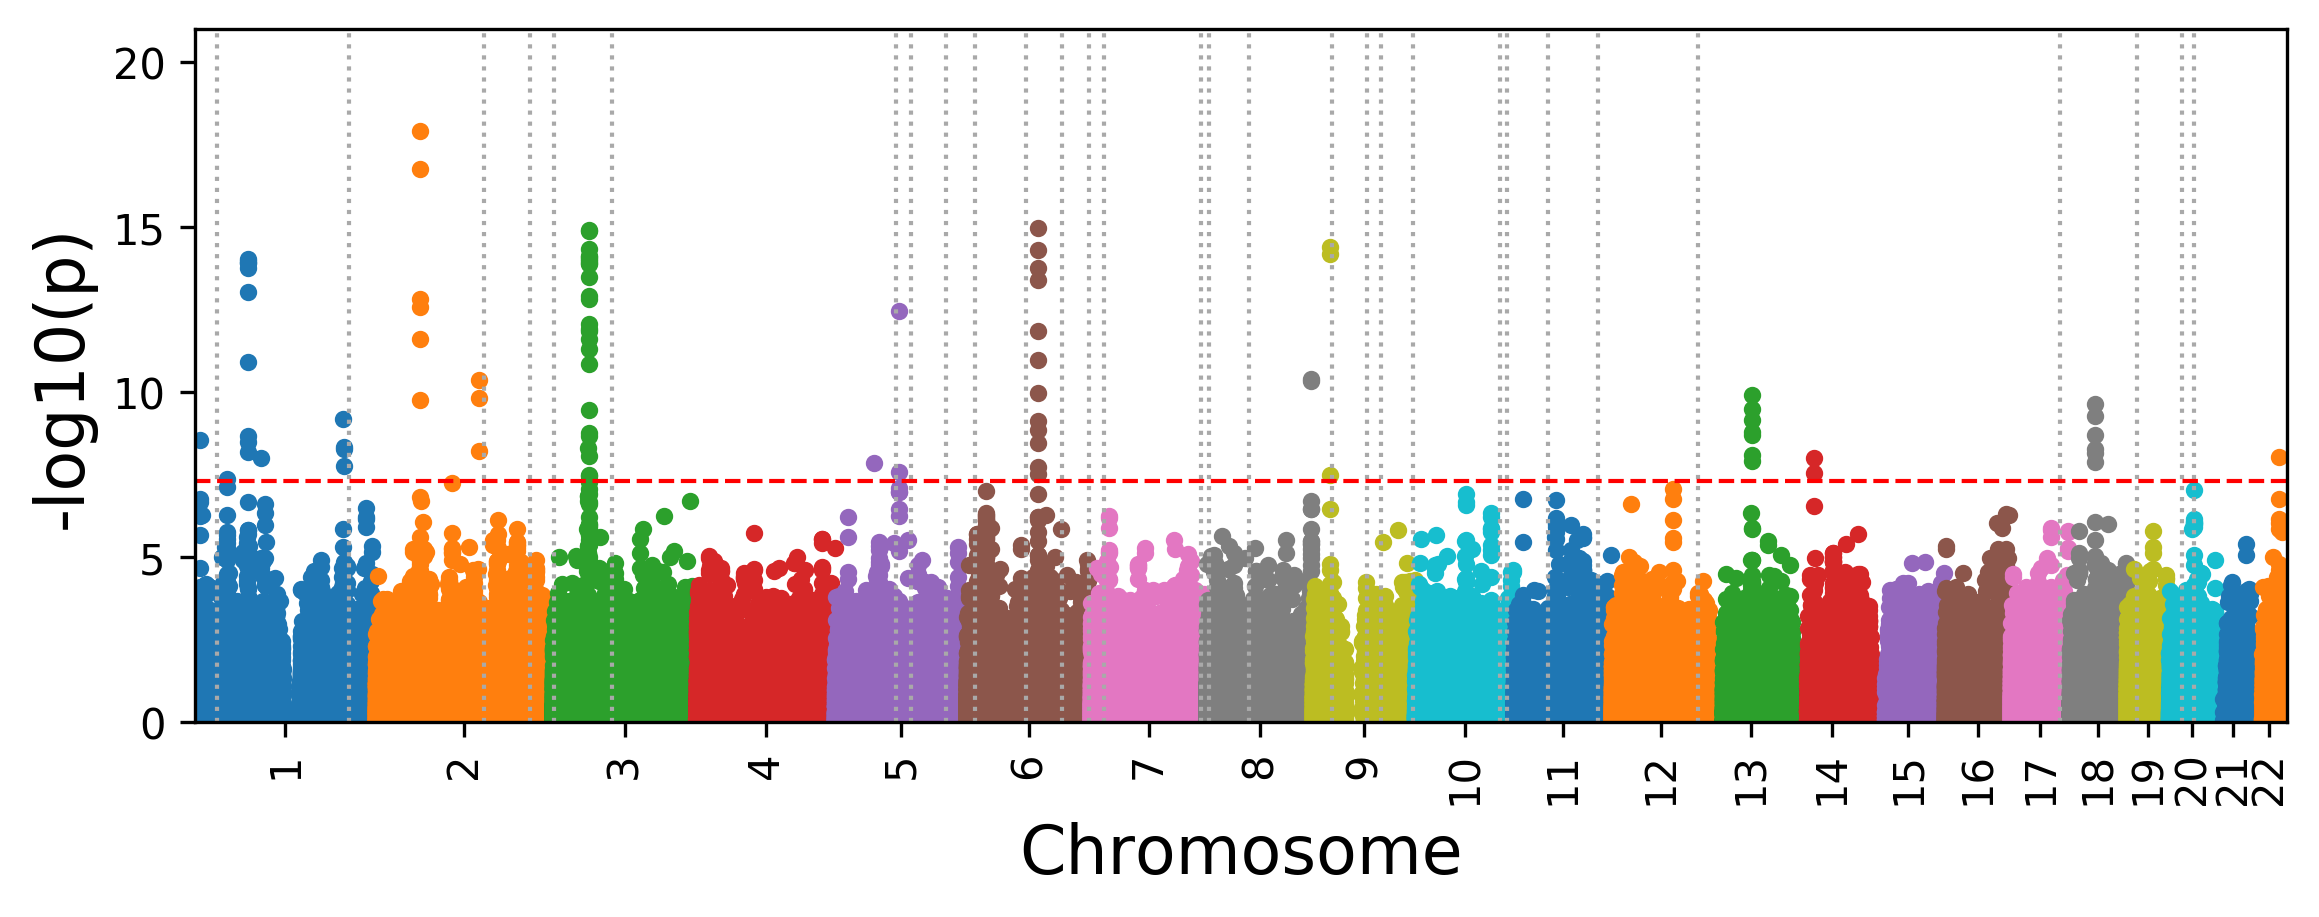

In [14]:
lonelinessTraits = ['loneliness']
loneliness_snps, loneliness_pvals = get_top_snps_from_gwas(gwas_catalog,traits,lonelinessTraits)
loneliness_snp_locs = get_position_dict(loneliness_snps[:30],gwas_catalog_positions)
loneliness_ps = [loneliness_pvals[x] for x in loneliness_snps]
manhattanPlot(positionDict, pvalDict, 21, loneliness_snp_locs)

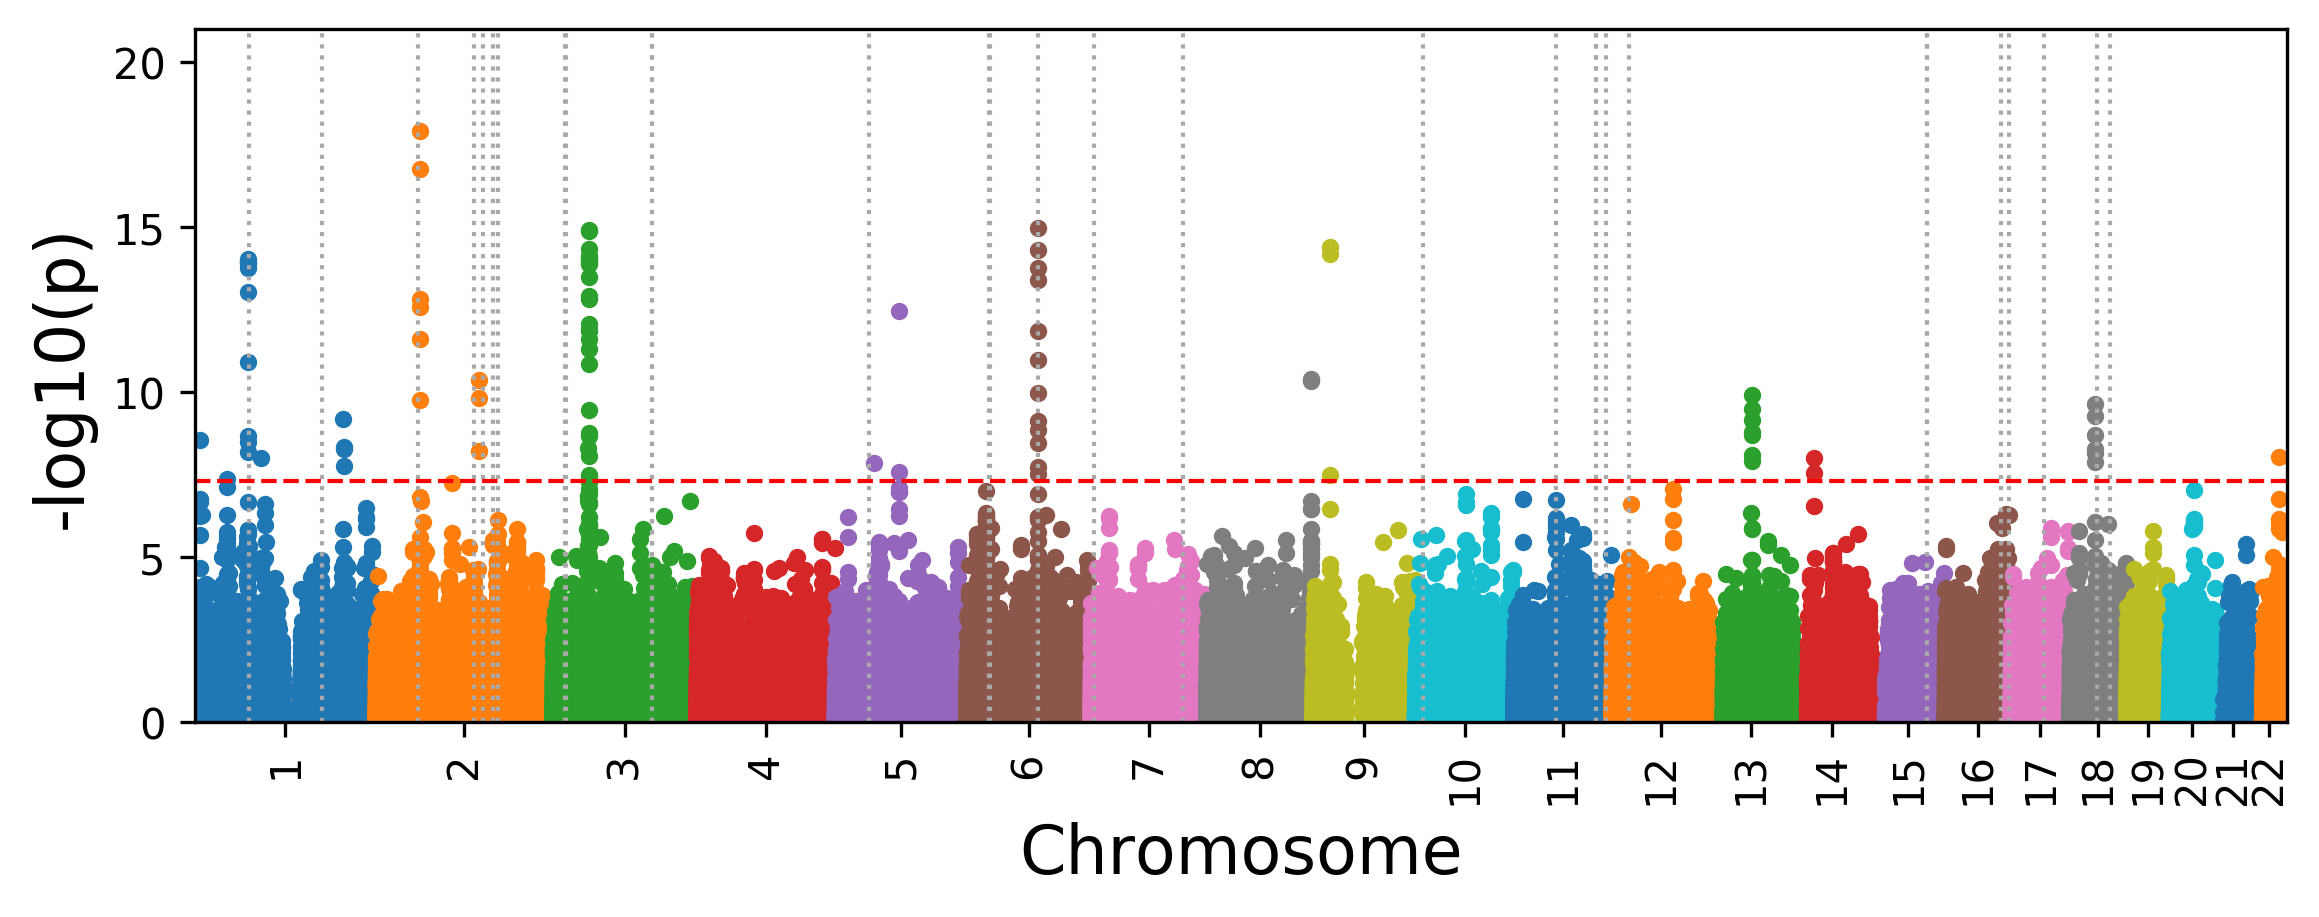

In [15]:
neuroticismTraits = ['neuroticism']
neuroticism_snps, neuroticism_pvals = get_top_snps_from_gwas(gwas_catalog,traits,neuroticismTraits)
neuroticism_snp_locs = get_position_dict(neuroticism_snps[:30],gwas_catalog_positions)
neuroticism_ps = [neuroticism_pvals[x] for x in neuroticism_snps]
manhattanPlot(positionDict, pvalDict, 21, neuroticism_snp_locs)

['alcohol consumption (drinks per week)', 'alcohol consumption (drinks per week) (mtag)', 'alcohol consumption (max-drinks)']


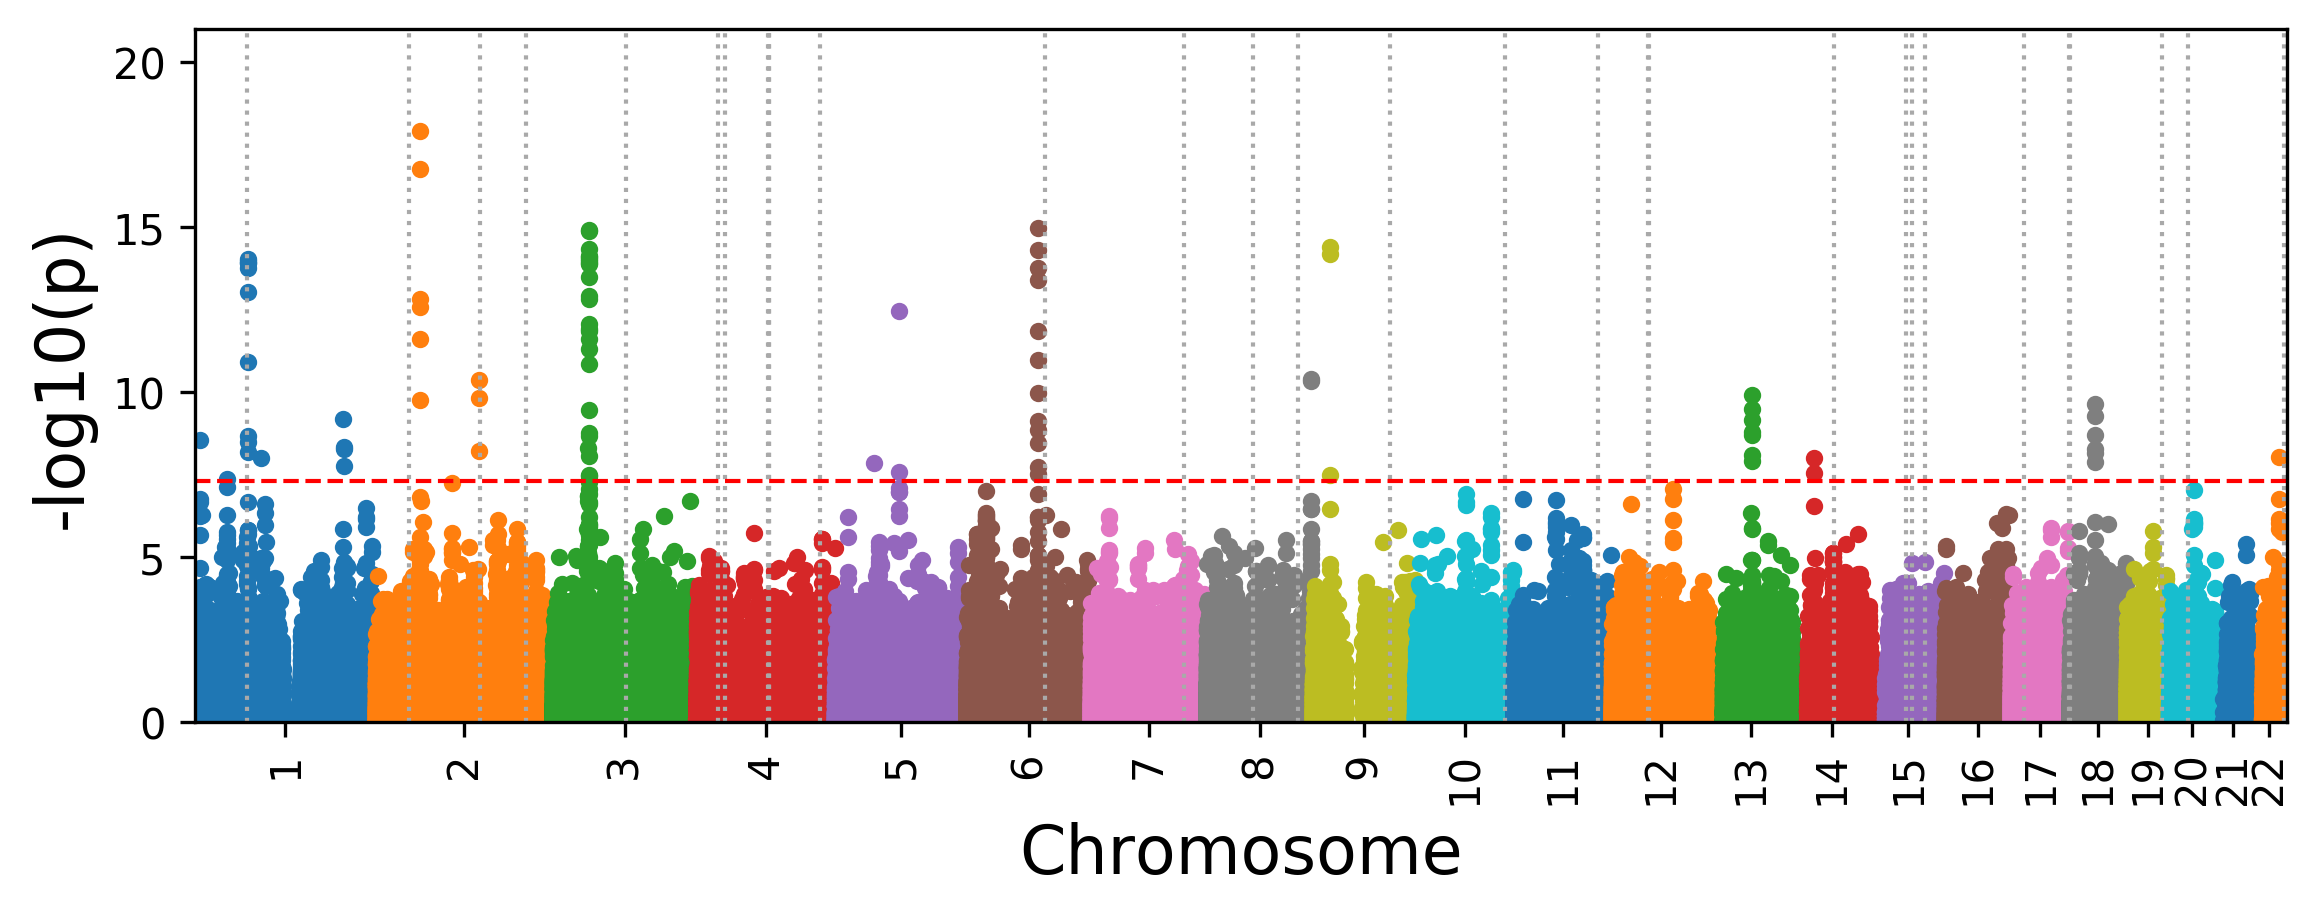

In [16]:
alcohol = ['drinks per week','max-drinks']
alcohol = ['drinks per week','max-drinks']
alcoholTraits = []
for s in alcohol:
    alcoholTraits.extend([x for x in traits if s in x])
print(alcoholTraits)
alcohol_snps, alcohol_pvals = get_top_snps_from_gwas(gwas_catalog,traits,alcoholTraits)
alcohol_snp_locs = get_position_dict(alcohol_snps[:30],gwas_catalog_positions)
alcohol_ps = [alcohol_pvals[x] for x in alcohol_snps]
manhattanPlot(positionDict, pvalDict, 21, alcohol_snp_locs)

['risk-taking tendency (4-domain principal component model)', 'self-reported risk-taking behaviour', 'adventurousness', 'general risk tolerance (mtag)']


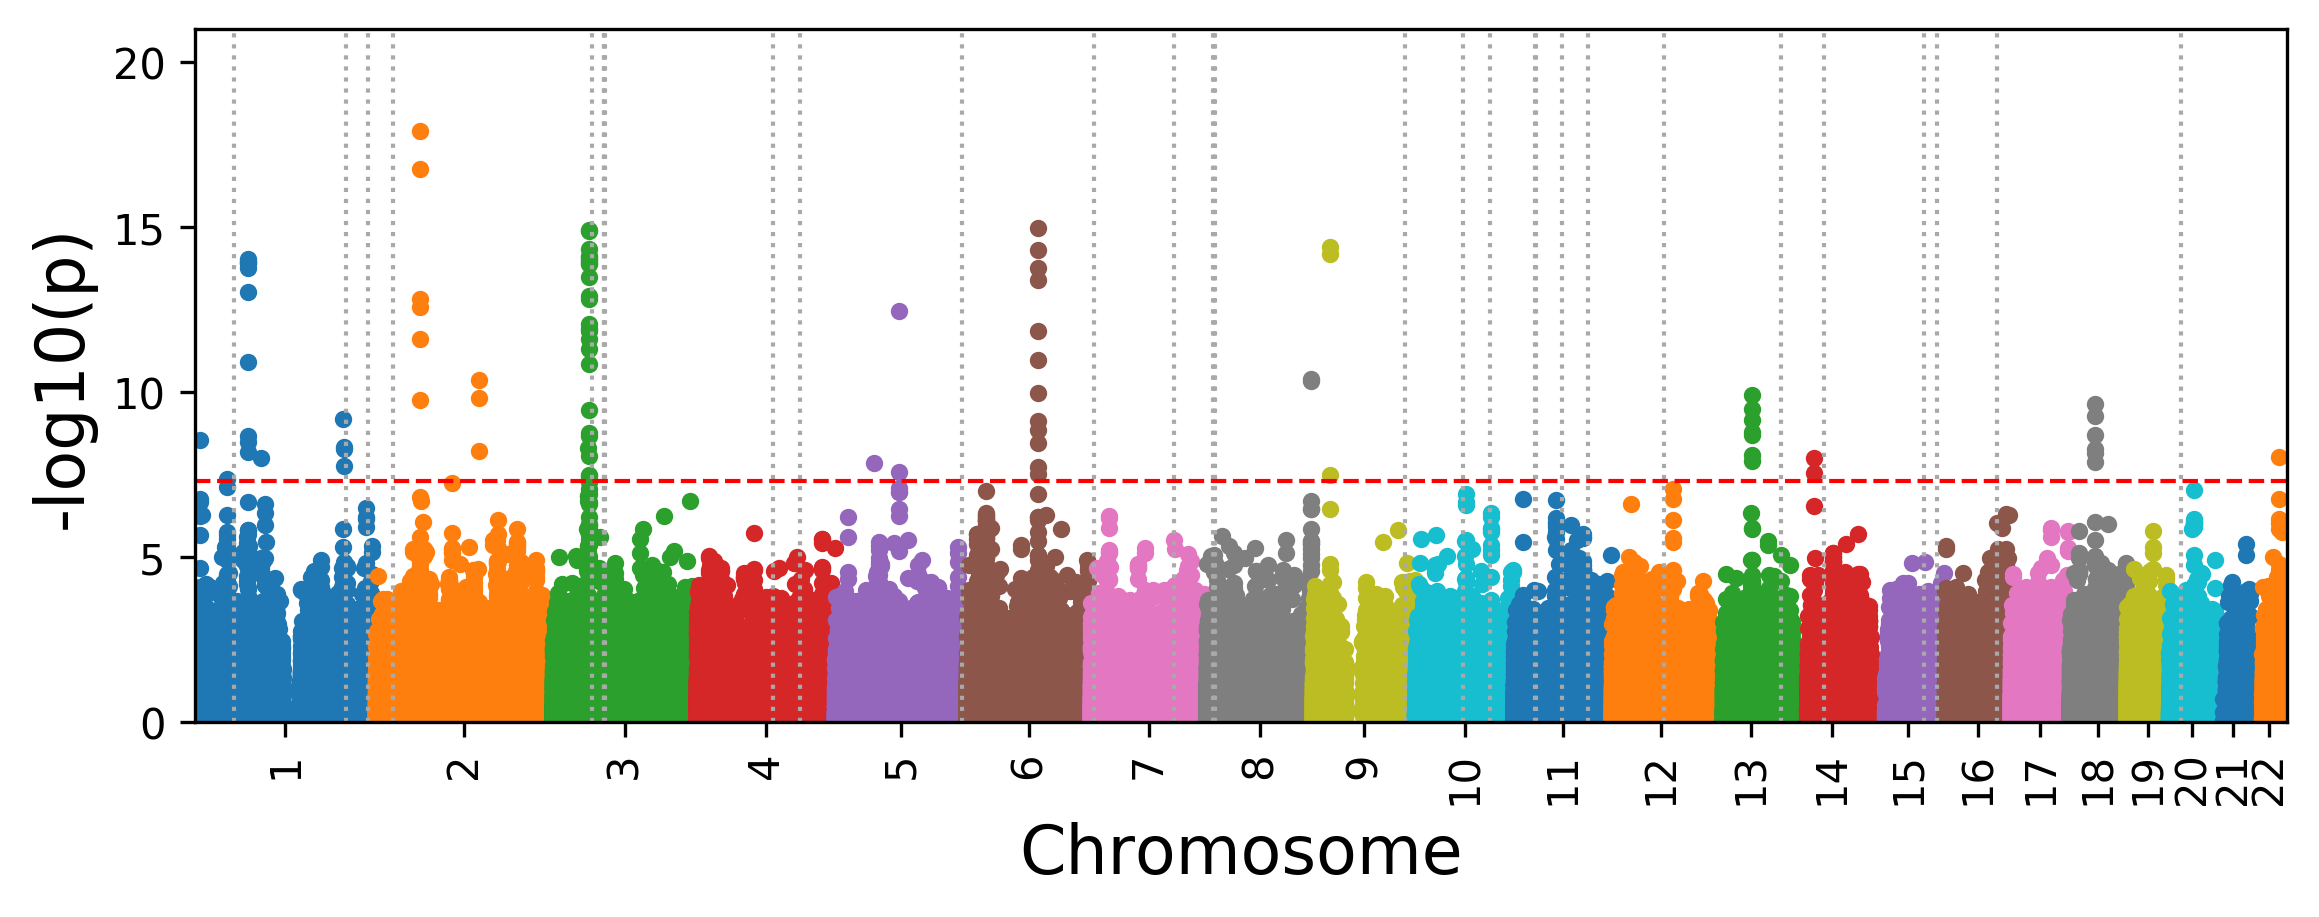

In [17]:
risk = ['risk-taking','adventurousness','risk tolerance']
riskTraits = []
for s in risk:
    riskTraits.extend([x for x in traits if s in x])
print(riskTraits)
risk_snps, risk_pvals = get_top_snps_from_gwas(gwas_catalog,traits,riskTraits)
risk_snp_locs = get_position_dict(risk_snps[:30],gwas_catalog_positions)
risk_ps = [risk_pvals[x] for x in risk_snps]
manhattanPlot(positionDict, pvalDict, 21, risk_snp_locs)

['waist circumference adjusted for bmi (adjusted for smoking behaviour)', 'smoking behaviour (cigarettes smoked per day)', 'waist-to-hip ratio adjusted for bmi (adjusted for smoking behaviour)', 'smoking behaviour (maximum cigarettes in a 24 hour period)', 'bmi (adjusted for smoking behaviour)', 'body mass index (ever vs never smoking interaction)', 'waist-to-hip circumference ratio (ever vs never smoking interaction)']


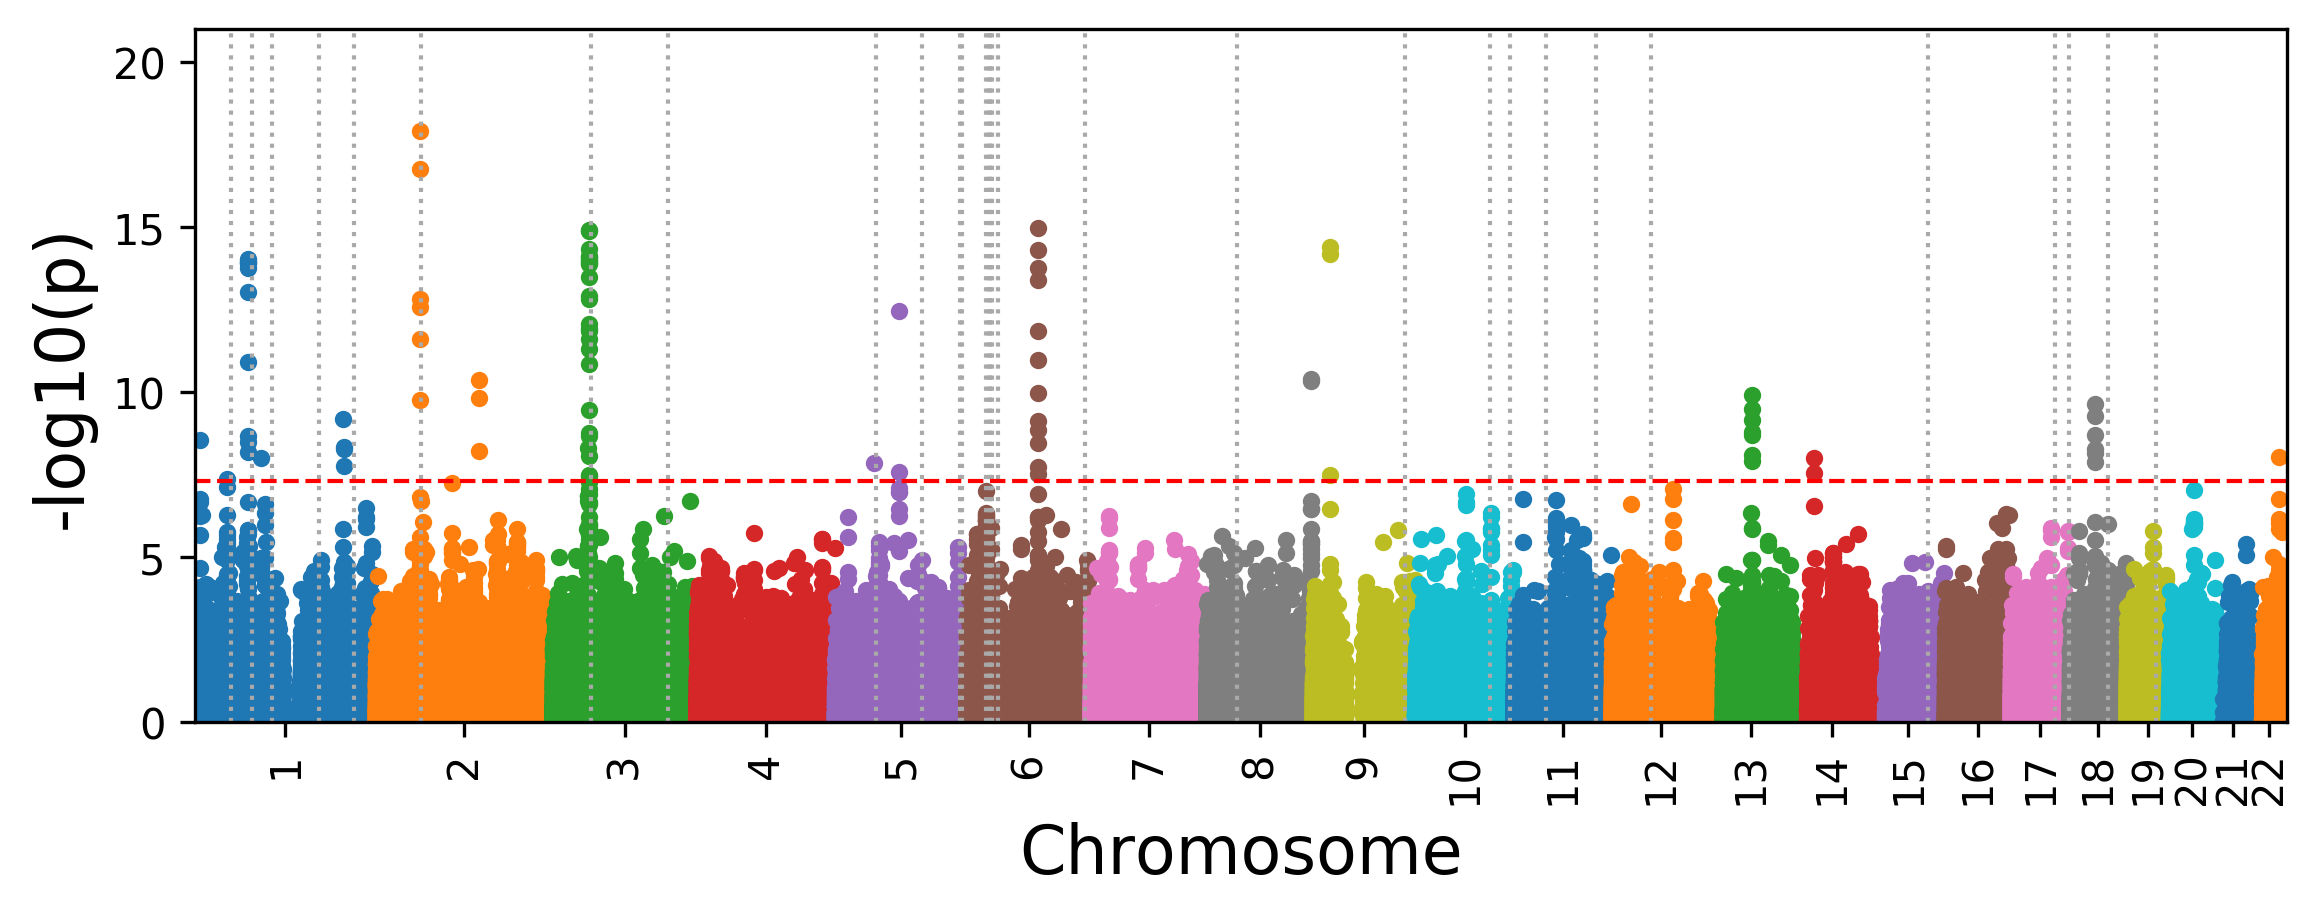

In [18]:
smoking = ['smoking behaviour','ever smoking']
smokingTraits = []
for s in smoking:
    smokingTraits.extend([x for x in traits if s in x])
print(smokingTraits)
smoking_snps, smoking_pvals = get_top_snps_from_gwas(gwas_catalog,traits,smokingTraits)
smoking_snp_locs = get_position_dict(smoking_snps[:30],gwas_catalog_positions)
smoking_ps = [smoking_pvals[x] for x in smoking_snps]
manhattanPlot(positionDict, pvalDict, 21, smoking_snp_locs)

# look at PLINK mover status GWAS

In [6]:
fstem = 'chr'
fdir = 'moverstatus_wbabornclose_propcs40/'
plinkPositions, plinkVariants, plinkPvals, plinkBetas, plinkErrors = load_chromosomes(fstem,fdir)

moverstatus_wbabornclose_propcs40/chr1.all.glm.logistic
done loading chromosomes


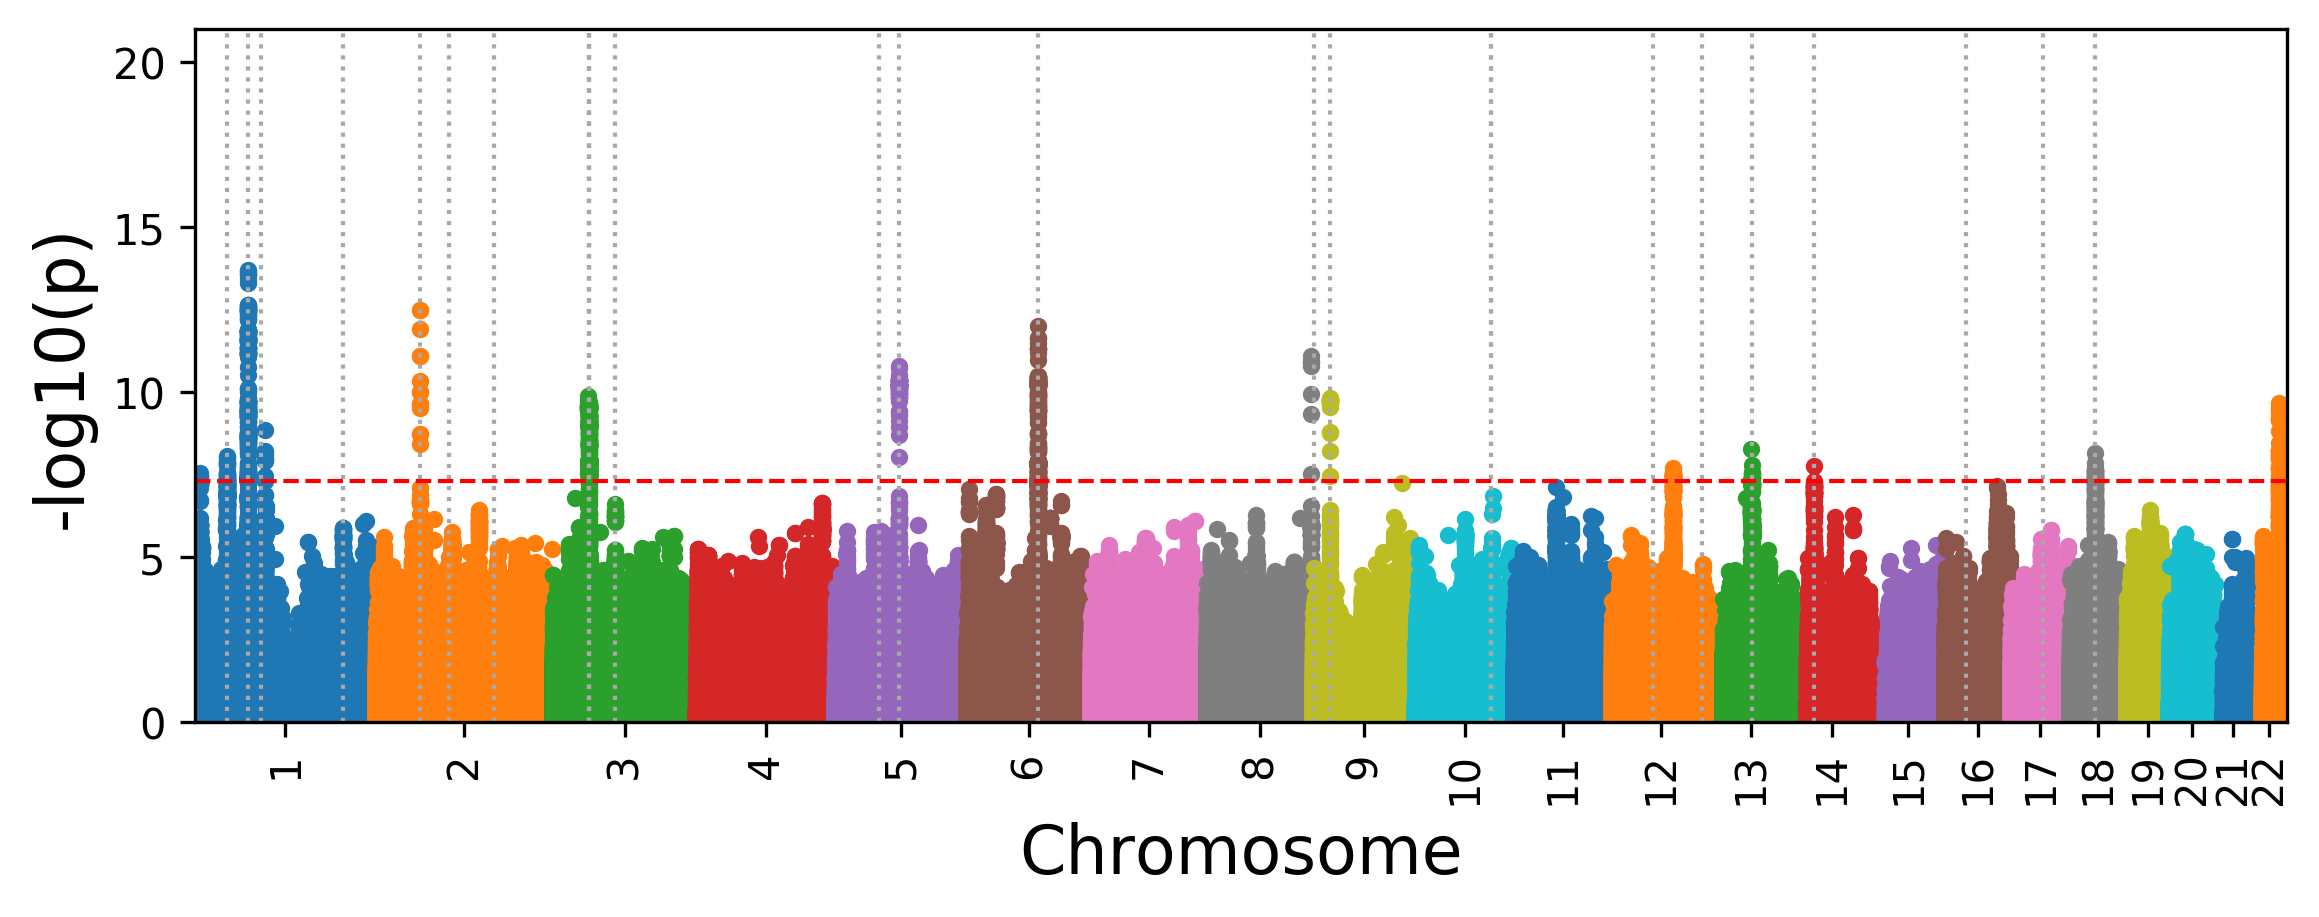

In [7]:
plt.style.use('default')
manhattanPlotGenome(plinkPositions,plinkPvals,21,ea_snp_locs)

In [8]:
fstem = 'chr'
fdir = 'mover_status/'
plinkPositions, plinkVariants, plinkPvals, plinkBetas, plinkErrors = load_chromosomes(fstem,fdir)

mover_status/chr1.all.glm.logistic
done loading chromosomes


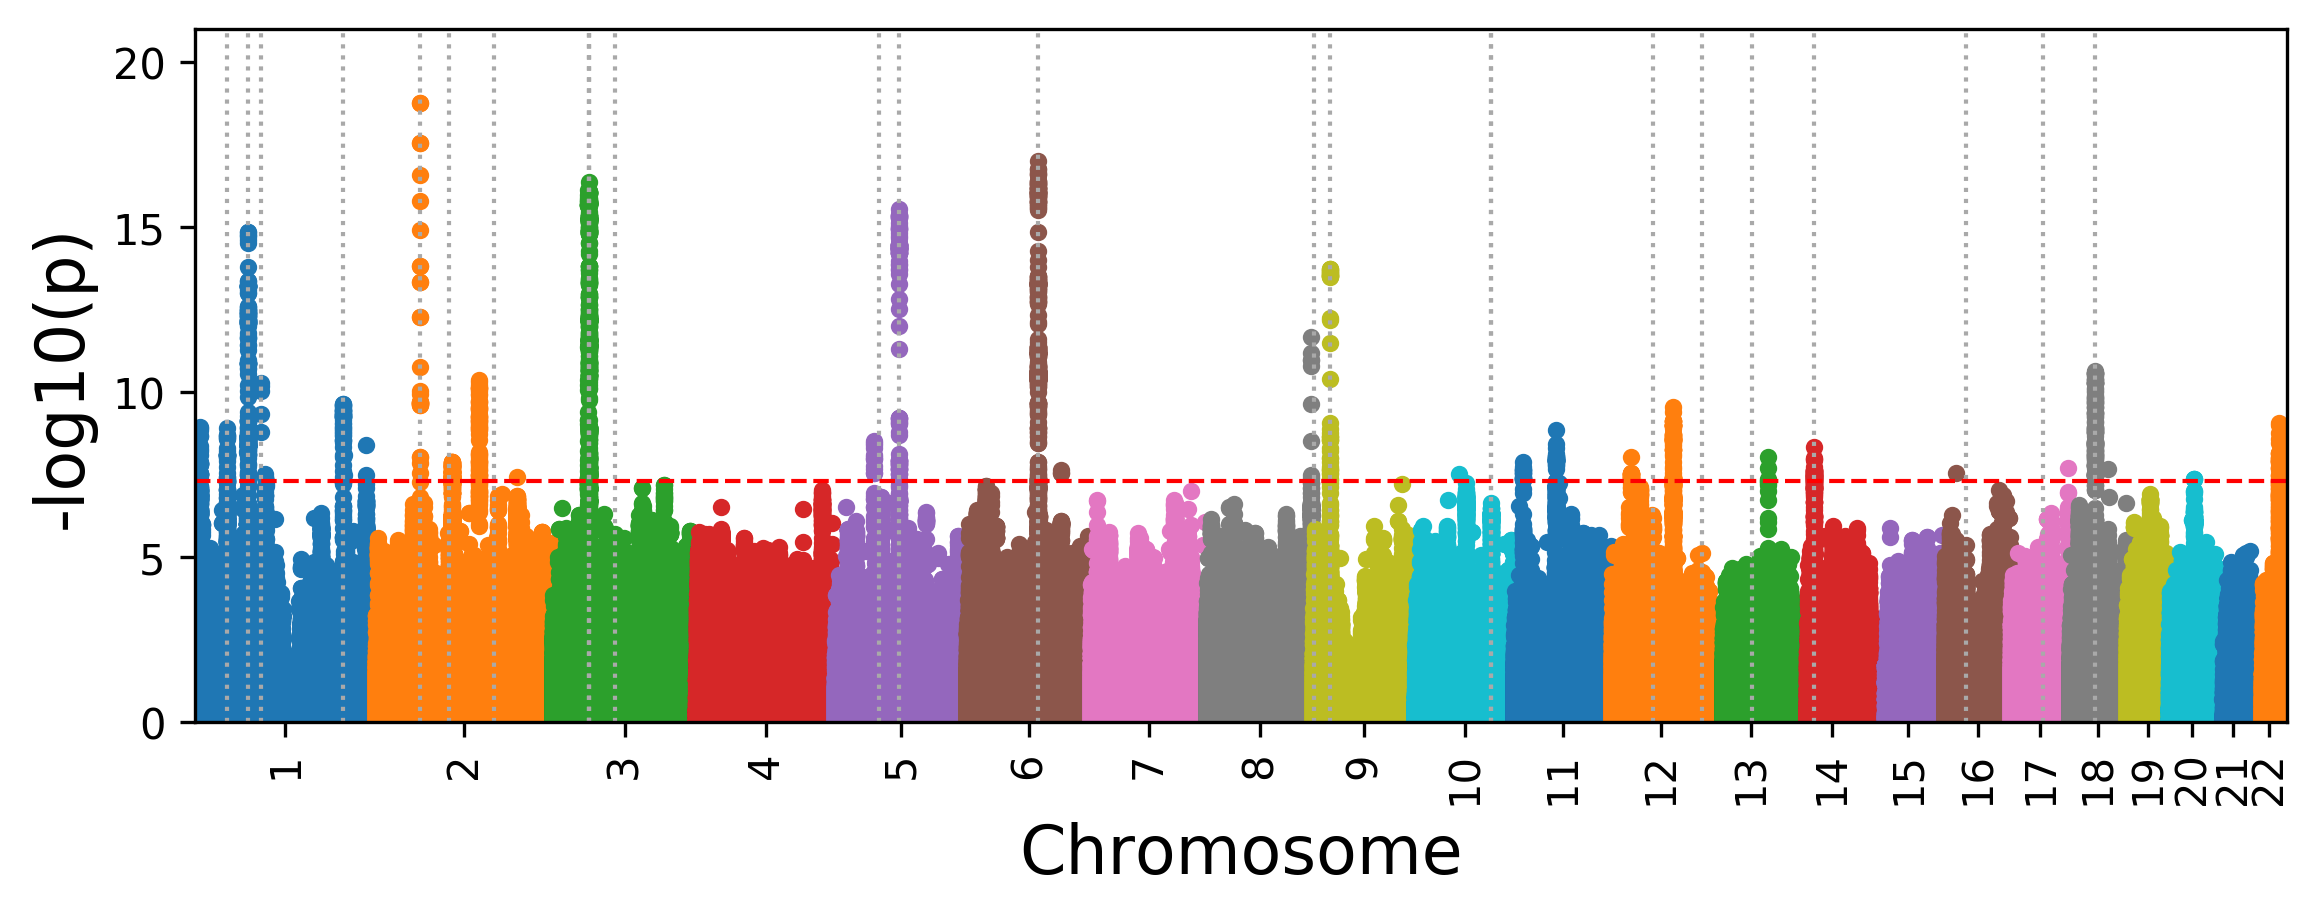

In [9]:
plt.style.use('default')
manhattanPlotGenome(plinkPositions,plinkPvals,21,ea_snp_locs)

# mover vs stayer GWAS

In [3]:
!ls bolt*

bolt_allukbsnps_lee:
movers_eduyears_allgenotyped.tab  stayers_eduyears_allgenotyped.tab

bolt_bmi:
movers_bmi_mafhweleegiant.tab  stayers_bmi_mafhweleegiant.tab

bolt_ea_female:
allwbafemalemover_mafhweleegiant_snps.tab
allwbafemalestayer_mafhweleegiant_snps.tab

bolt_ea_male:
allwbamalemover_mafhweleegiant_snps.tab
allwbamalestayer_mafhweleegiant_snps.tab

bolt_ea_male_v_female:
allwbafemale_mafhweleegiant_snps.tab allwbamale_mafhweleegiant_snps.tab

bolt_height:
movers_height_mafhweleegiant.tab  stayers_height_mafhweleegiant.tab

bolt_moverstatus:
moverstatus_allgenotyped.tab

bolt_moverstatus_allwba_eacovar:
lmm_moverstatus_allwba.tab

bolt_ms_pca_lee:
movers_eduyears.tab  stayers_eduyears.tab


In [4]:
stayer_gwas = pd.read_csv('bolt_height/stayers_height_mafhweleegiant.tab',delimiter = '\t')
stayerPositionDict, stayerPvalDict = boltChromPositionsPvals(stayer_gwas)
stayer_gwas.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM
0,rs28659788,1,723307,0.004160,C,G,0.987241,0.064237,0.110270,0.080322,0.17,0.28
1,rs116587930,1,727841,0.004294,G,A,0.963776,0.074108,-0.066558,0.048363,0.17,0.12
2,rs116720794,1,729632,0.004349,C,T,0.967254,0.008608,0.071431,0.049792,0.15,0.18


In [5]:
mover_gwas = pd.read_csv('bolt_height/movers_height_mafhweleegiant.tab',delimiter = '\t')
moverPositionDict, moverPvalDict = boltChromPositionsPvals(mover_gwas)
mover_gwas.head(3)

,SNP,CHR,BP,GENPOS,ALLELE1,ALLELE0,A1FREQ,F_MISS,BETA,SE,P_BOLT_LMM_INF,P_BOLT_LMM
0,rs28659788,1,723307,0.004160,C,G,0.986695,0.065422,-0.071130,0.085100,0.40,0.860
1,rs116587930,1,727841,0.004294,G,A,0.963511,0.074909,-0.032719,0.052145,0.53,0.600
2,rs116720794,1,729632,0.004349,C,T,0.965777,0.008538,0.053718,0.052678,0.31,0.061


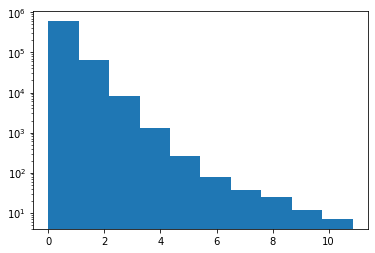

In [6]:
plt.hist(-np.log10(stayer_gwas.P_BOLT_LMM_INF))
plt.yscale('log')
plt.show()

In [30]:
# getting standard snp set for BMI
bmi_giant = pd.read_csv('Locke_GIANT_bmi_snps.txt',delimiter = '\t')
snplist = bmi_giant.SNP.tolist()
print(len(snplist))
print(snplist[:5])
snp_list_no_dups = list(set(snplist))
print(len(snp_list_no_dups))
bmi_snps = snp_list_no_dups

# add these snp positions to manhattan plot?
num_to_get = 33
topPvals = bmi_giant.sort_values(by='P',ascending = True).head(num_to_get)

# make dictionary ... key = Chr, vals = list of positions
bmi_snp_locs = {}
for chrom in np.arange(1,23):
    thisChrom = topPvals[topPvals.CHR==chrom].POS.tolist()
    if len(thisChrom) > 0:
        bmi_snp_locs[chrom] = sorted(thisChrom)
snplist = bmi_snps

941
['rs1000096', 'rs1000940', 'rs1003081', 'rs10035289', 'rs10037047']
941


In [6]:
# getting standard snp set for HEIGHT
# getting standard snp set for HEIGHT
height_giant = pd.read_csv('giant_locke_2018_height_snps.txt',delimiter = '\t')
snplist = height_giant.SNP.tolist()
print(len(snplist))
print(snplist[:5])
snp_list_no_dups = list(set(snplist))
print(len(snp_list_no_dups))
height_snps = snp_list_no_dups
snplist = height_snps

# add these snp positions to manhattan plot?
num_to_get = 33
topPvals = height_giant.sort_values(by='P',ascending = True).head(num_to_get)

# make dictionary ... key = Chr, vals = list of positions
height_snp_locs = {}
for chrom in np.arange(1,23):
    thisChrom = topPvals[topPvals.CHR==chrom].POS.tolist()
    if len(thisChrom) > 0:
        height_snp_locs[chrom] = sorted(thisChrom)

3290
['rs10003497', 'rs1000410', 'rs10008015', 'rs10010325', 'rs10016290']
3290


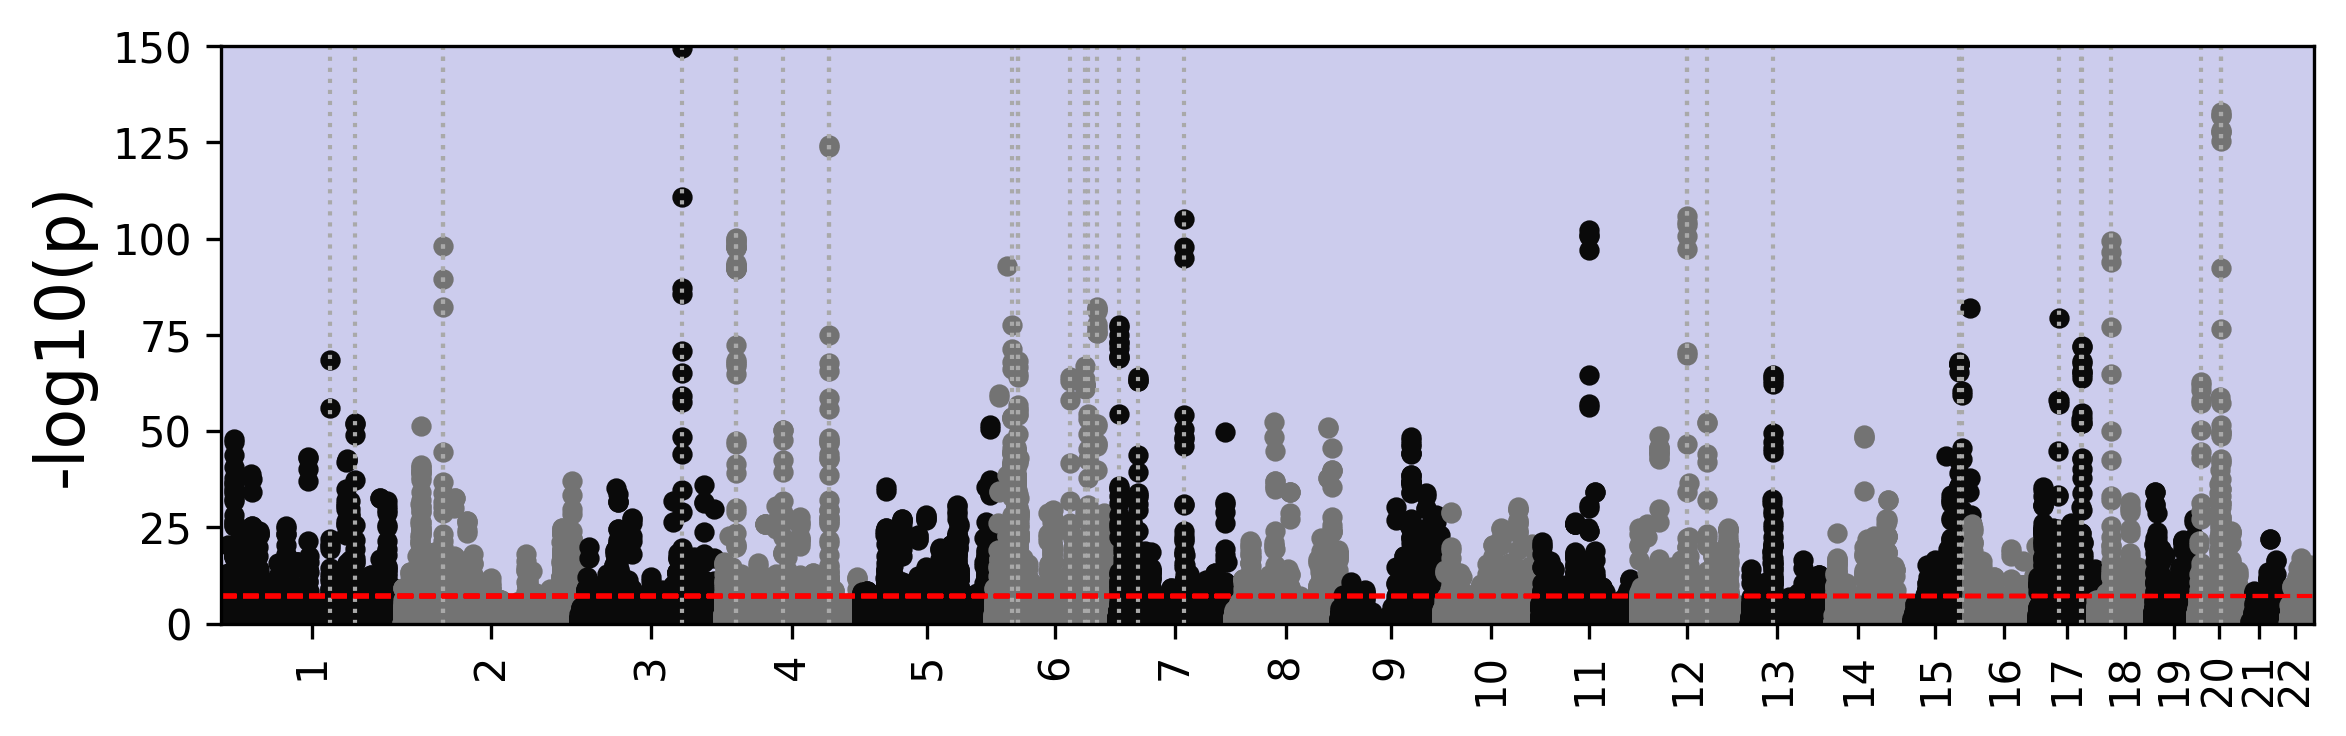

In [11]:
#manhattanPlot(stayerPositionDict, stayerPvalDict, 30, ea_snp_locs)
manhattanPlotGenome(stayerPositionDict,stayerPvalDict,150,snp_locs=height_snp_locs,flip=False,axcolor=[0.8,0.8,0.93])

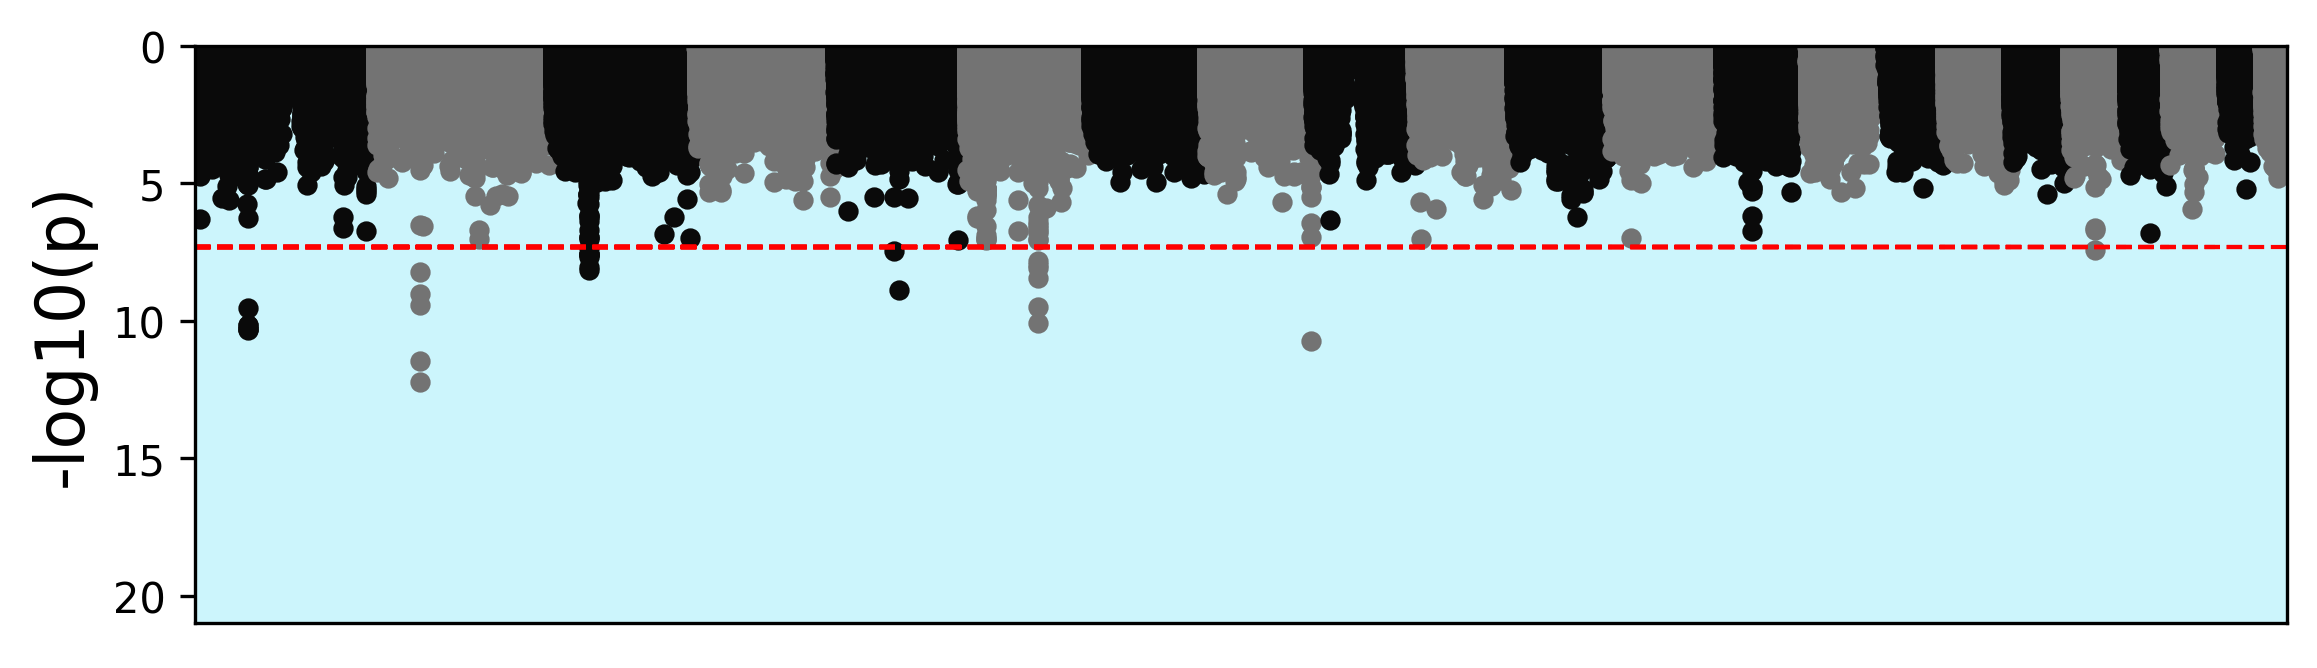

In [10]:
#manhattanPlot(moverPositionDict, moverPvalDict, 30, ea_snp_locs)
manhattanPlotGenome(moverPositionDict,moverPvalDict,21,snp_locs={},flip=True,axcolor=[0.8,0.96,0.99])

In [7]:
# Compare pvals, including the snps of interest
stayerPvals = dict(zip(stayer_gwas.SNP,stayer_gwas.P_BOLT_LMM_INF))
moverPvals =  dict(zip(mover_gwas.SNP,mover_gwas.P_BOLT_LMM_INF))

snps_in_both = list(set(stayerPvals.keys())&set(moverPvals.keys()))

all_xvals = np.array([stayerPvals[x] for x in snps_in_both])
all_yvals = np.array([moverPvals[x] for x in snps_in_both])

In [ ]:
f,a = plt.subplots(1,1,figsize=(4,4),dpi=150)
plt.style.use('default')
a.scatter(-np.log10(all_xvals),-np.log10(all_yvals), s=10, c = 'g', label='all snps')

snp_xvals = [stayerPvals[x] for x in snplist if x in snps_in_both ]
snp_yvals = [moverPvals[x] for x in snplist  if x in snps_in_both ]

f,a = plt.subplots(1,1,figsize=(4,4),dpi=150)
a.scatter(-np.log10(snp_xvals),-np.log10(snp_yvals), s=5, c = 'k', marker = 'x', label='Height snps')

a.plot([0,18],[0,18],'--r')
a.set_xlabel('Stayer p-vals',fontsize=16)
a.set_ylabel('Mover p-vals',fontsize=16)
a.set_title('BOLT-LMM Stayers vs Movers:\nUKB Genotyped snps')
plt.legend(fontsize=12)
plt.show()

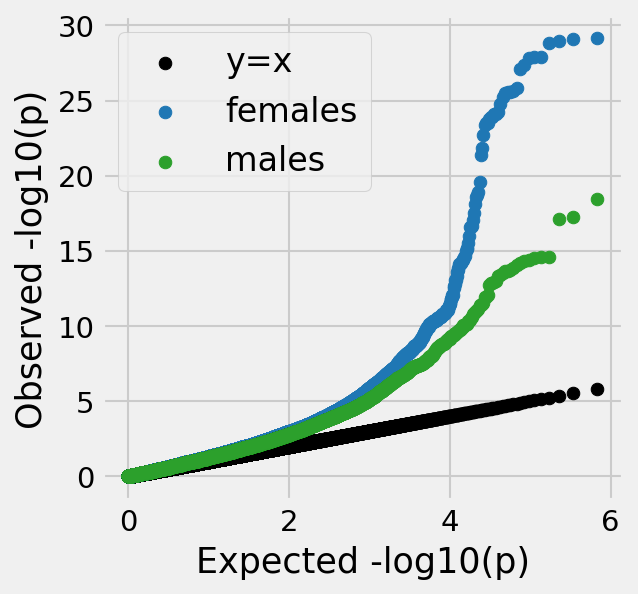

In [16]:
# make a qqplot
xvals_noNan = all_xvals[np.isnan(all_xvals)==False]
yvals_noNan = all_yvals[np.isnan(all_yvals)==False]
qqplot([xvals_noNan,yvals_noNan],['females','males'],fs=(4,4))

In [17]:
# lambda_GC Genomic control
median_stayerP = np.median(xvals_noNan)
median_moverP = np.median(yvals_noNan)

median_stayerChi = stats.chi2.isf(median_stayerP, 1)
median_moverChi = stats.chi2.isf(median_moverP, 1)

lambda_gc_stayer = median_stayerChi / (0.675**2)
lambda_gc_mover = median_moverChi / (0.675**2)
print('lambda_gc stayers: ','{:1.2f}'.format(lambda_gc_stayer))
print('lambda_gc movers: ', ' {:1.2f}'.format(lambda_gc_mover))

lambda_gc stayers:  1.37
lambda_gc movers:   1.25


In [18]:
sb = dict(zip(stayer_gwas.SNP,stayer_gwas.BETA))
se = dict(zip(stayer_gwas.SNP,stayer_gwas.SE))
mb = dict(zip(mover_gwas.SNP,mover_gwas.BETA))
me = dict(zip(mover_gwas.SNP,mover_gwas.SE))

In [19]:
snplist = ea_snps
snplist_betas_1  = np.array([sb[x] for x in snplist if x in sb.keys()])
snplist_errors_1 = np.array([se[x] for x in snplist if x in se.keys()])
snplist_betas_2  = np.array([mb[x] for x in snplist if x in sb.keys()]) # should be mb
snplist_errors_2 = np.array([me[x] for x in snplist if x in se.keys()]) # should be me
print(len(snplist_betas_1),len(snplist_errors_1))
print(len(snplist_betas_2),len(snplist_errors_2))

1254 1254
1254 1254


In [20]:
# magnitude ... do abs() unless signs opposite
# if sign switch .... make the larger one positive, and the smaller one negative

snplist_betas_1_magnitude = []
snplist_betas_2_magnitude = []

for i, sb1 in enumerate(snplist_betas_1):
    sb2 = snplist_betas_2[i]
    if (sb1 < 0 and sb2 < 0) or (sb1 >= 0 and sb2 >= 0):
        snplist_betas_1_magnitude.append(abs(sb1))
        snplist_betas_2_magnitude.append(abs(sb2))
        
    else: # if sign switch .... make the larger one positive, and the smaller one negative
        
        if abs(sb1) > abs(sb2):
            snplist_betas_1_magnitude.append(abs(sb1))
            snplist_betas_2_magnitude.append(-abs(sb2))
        else:
            snplist_betas_1_magnitude.append(-abs(sb1))
            snplist_betas_2_magnitude.append(abs(sb2))
print(len(snplist_betas_1_magnitude), len(snplist_betas_2_magnitude))

1254 1254


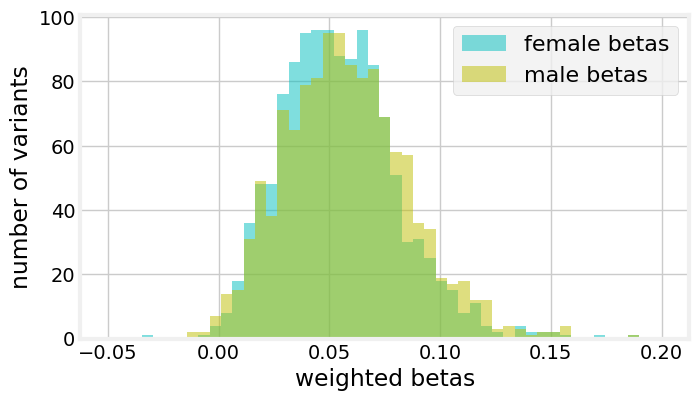

In [30]:
# let's look at those betas!
numBins = 50
plt.style.use('fivethirtyeight')
b1 = snplist_betas_1_magnitude
b2 = snplist_betas_2_magnitude

bins = np.linspace(-0.05, 0.2, numBins)

#f,(a1,a2) = plt.subplots(1,2,figsize = (14,4))
f,a2 = plt.subplots(1,1,figsize = (7,4), facecolor = 'w')

# a1.hist(b1,bins,alpha = 0.5, label='stayers unrelated-5', color = 'blue')
# a1.hist(b2,bins,alpha = 0.5, label='movers unrelated-5', color = 'green')
# a1.legend(loc='upper right', fontsize=16)
# a1.set_ylabel('number of variants')
# #plt.yscale('log')
# a1.set_xlabel('betas')
#plt.suptitle('Eduyears: 1252 Lee snps, 40 PCs UKB')

j1,j2,wb1 = get_weighted_avg_beta(b1,snplist_errors_1)
j1,j2,wb2 = get_weighted_avg_beta(b2,snplist_errors_2)
a2.hist(wb1,bins,alpha = 0.5, label='stayer betas', color = 'tab:blue')
a2.hist(wb2,bins,alpha = 0.5, label='mover betas', color = 'tab:green')
a2.set_xlabel('weighted betas')
a2.set_ylabel('number of variants')
a2.legend(loc='upper right', fontsize=16)
a2.set_facecolor('w')
plt.show()

In [22]:
zstat, eff1, eff2 = calc_z_statistic(b1,b2,
                         snplist_errors_1,snplist_errors_2,'stayers','movers')
p_values = stats.norm.sf(abs(zstat))*2
print('pval: ','{:1.1e}'.format(p_values))
print()
print('mover more: ', '{:1.1f}%'.format((eff2-eff1) * 100 / eff1))

stayers:  avg_eff 0.0546  variance: 2.432e-07
movers:  avg_eff 0.0578  variance: 3.172e-07

difference in effect:  -0.0032

z-statistic:  -4.3192
pval:  1.6e-05

mover more:  5.9%


In [23]:
wb1_nonan = wb1[~np.isnan(wb1)]
wb2_nonan = wb2[~np.isnan(wb2)]

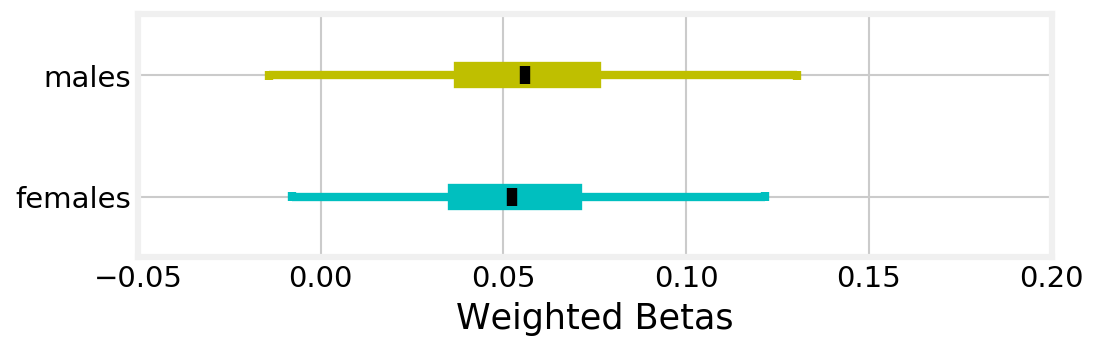

In [33]:
f,a = plt.subplots(1,1,figsize=(7,2),dpi=150,facecolor='w')
#cls = [[0.705,0,0.411],[0.24,0.51,0.1]]
#cls = ['tab:blue','tab:green']
cls = ['c','y'] # female male

bp = plt.boxplot(wb1_nonan, positions=[1], patch_artist=True, showfliers = False, vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color=cls[0] , linewidth = 4)
plt.setp(bp['medians'], color = 'k', linewidth = 5)

bp = plt.boxplot(wb2_nonan, positions=[2], patch_artist=True, showfliers = False, vert=False)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
    plt.setp(bp[element], color=cls[1], linewidth = 4)
plt.setp(bp['medians'], color = 'k', linewidth = 5)

plt.yticks([1,2],['females','males'])
plt.xlim([-0.05,0.2])
plt.xlabel('Weighted Betas')
plt.ylim([0.5,2.5])
a.set_facecolor('w')
plt.show()

In [34]:
# save for later
import pickle
fname = 'ea_female_v_male_boltlmm.p'
pickle.dump([wb1,wb2],open(fname,'wb'))